# AIMNet2 tmQM-OpenFF

## Import AIMNet2 tmQM-OpenFF trainings

In [1]:
import glob
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toml
import torch
import wandb

import helper
from helper import extract_config, calculate_reference_energy, test_nnp_with_fixed_tmqm_subset
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy
from modelforge.potential.potential import load_inference_model_from_checkpoint

sns.set_theme()
sns.set_context("notebook")

In [ ]:
api = wandb.Api()
runs = api.runs(
    "modelforge_nnps/aimnet2_tmqm_openff",
    filters={"group": "exp08_3"},
)
print(f"Found {len(runs)} runs")
summary_list, config_list, name_list = [], [], []

In [20]:
extract_config(runs[0].config["training_parameter"], "tags")

{'tags': ['seed=42',
  'sm_1_n_configs_10_v1.2',
  'per_system_energy=0.0001',
  'per_system_dipole_moment=0.1',
  'per_atom_charge=1',
  'spin_multiplicity_embedding',
  '0.1.4+300.gef9c8be.dirty',
  'tmqm_openff_local',
  'AimNet2',
  'loss-per_system_energy',
  'loss-per_system_dipole_moment',
  'loss-per_atom_charge']}

In [21]:
runs[0].summary["val/per_system_energy/mae"]

64.59003448486328

In [22]:
test_results = []

for run in runs:
    if run.state == "finished":
        record = {}
    
        record.update({"name": run.name})
        
        training_parameter = run.config["training_parameter"]
        potential_parameter = run.config['potential_parameter']
        tags = extract_config(training_parameter, "tags")["tags"]

        try:
            record.update({
                "test/per_system_energy/mae": run.summary["test/per_system_energy/mae"],
                "test/per_system_energy/rmse": run.summary["test/per_system_energy/rmse"],
            })
        except KeyError:
            record.update({
                "test/per_system_energy/mae": pd.NA,
                "test/per_system_energy/rmse": pd.NA,
            })
        record.update({
                "val/per_system_energy/mae": run.summary["val/per_system_energy/mae"],
                "val/per_system_energy/rmse": run.summary["val/per_system_energy/rmse"],
                "val/per_system_dipole_moment/mae": run.summary["val/per_system_dipole_moment/mae"],
                "val/per_atom_charge/mae": run.summary["val/per_atom_charge/mae"],
            })
        
        record.update(extract_config(potential_parameter, "number_of_radial_basis_functions"))
        record.update(extract_config(potential_parameter, "number_of_vector_features"))
        record.update(extract_config(potential_parameter, "number_of_per_atom_features"))

        loss_weights = extract_config(training_parameter, "weight")
        record.update(loss_weights["weight"])

        record["dataset_version"] = extract_config(run.config["training_parameter"], "tags")["tags"][1]
        if "spin_multiplicity_embedding" in tags:
            record["spin_embedding"] = True
        else:
            record["spin_embedding"] = False

        record["group"] = run.group
        record.update(
            extract_config(training_parameter, "seed")
        )
        test_results.append(record)

test_results_df = pd.DataFrame(test_results)

In [23]:
test_results_df.sort_values(by="val/per_system_energy/mae").head(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
75,"full_dataset_v1.2_[0.0001, 0, 1]_(46)",<NA>,<NA>,46.471733,85.297318,0.136738,0.024444,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,46
62,"full_dataset_v1.2_[0.0001, 0, 1]_(45)",<NA>,<NA>,47.071945,86.559341,0.147555,0.035212,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,45
1,"sm_1_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",<NA>,<NA>,47.190578,83.477081,0.149201,0.028612,64,8,128,0.0001,0.0,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
44,"full_dataset_v1.2_[0.0001, 0.1, 0]_(44)",<NA>,<NA>,48.061447,86.444557,0.140324,0.189907,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,44
28,"full_dataset_v1.2_[0.0001, 0.1, 0]_(43)",<NA>,<NA>,50.162586,95.537132,0.139438,0.171702,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,43
27,"full_dataset_v1.2_[0.0001, 0, 1]_(43)",<NA>,<NA>,50.529491,92.023438,0.145163,0.029573,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,43
6,"sm_3_n_configs_10_v1.2_[0.0001, 0, 1]_(42)",<NA>,<NA>,50.572193,86.348091,0.146770,0.032781,64,8,128,0.0001,0.0,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42
4,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 0]_(42)",<NA>,<NA>,50.832760,91.653175,0.149640,0.226110,64,8,128,0.0001,0.1,0.0,sm_1_n_configs_10_v1.2,True,exp08_3,42
52,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 0]_(45)",<NA>,<NA>,51.941250,91.402840,0.148569,0.182785,64,8,128,0.0001,0.1,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,45
2,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(42)",<NA>,<NA>,52.086086,93.028130,0.135807,0.030554,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,42


In [24]:
test_results_df.sort_values(by="val/per_system_energy/mae").tail(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
29,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(44)",<NA>,<NA>,67.414452,105.232948,0.152157,0.037135,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,44
26,"full_dataset_v1.2_[0.0001, 0.1, 1]_(43)",<NA>,<NA>,67.492081,110.152657,0.137710,0.032168,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,43
55,"sm_5_n_configs_10_v1.2_[0.0001, 0, 1]_(45)",<NA>,<NA>,67.892853,105.677513,0.170731,0.040489,64,8,128,0.0001,0.0,1.0,sm_5_n_configs_10_v1.2,True,exp08_3,45
25,"sm_5_n_configs_10_v1.2_[1, 0, 0]_(43)",<NA>,<NA>,68.123634,104.998306,0.190058,0.189299,64,8,128,1.0000,0.0,0.0,sm_5_n_configs_10_v1.2,True,exp08_3,43
38,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 0]_(44)",<NA>,<NA>,68.544792,104.309006,0.163397,0.201254,64,8,128,0.0001,0.1,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,44
9,"sm_5_n_configs_10_v1.2_[0.0001, 0.1, 0]_(42)",<NA>,<NA>,68.608894,101.403755,0.153433,0.217342,64,8,128,0.0001,0.1,0.0,sm_5_n_configs_10_v1.2,True,exp08_3,42
22,"sm_5_n_configs_10_v1.2_[0.0001, 0, 1]_(43)",<NA>,<NA>,70.108772,105.246208,0.182263,0.050805,64,8,128,0.0001,0.0,1.0,sm_5_n_configs_10_v1.2,True,exp08_3,43
69,"sm_3_n_configs_10_v1.2_[1, 0, 0]_(46)",<NA>,<NA>,70.142609,107.817757,0.186408,0.183132,64,8,128,1.0000,0.0,0.0,sm_3_n_configs_10_v1.2,True,exp08_3,46
47,"sm_1_n_configs_10_v1.2_[0.0001, 0.1, 1]_(45)",<NA>,<NA>,70.151108,107.077286,0.170627,0.057848,64,8,128,0.0001,0.1,1.0,sm_1_n_configs_10_v1.2,True,exp08_3,45
34,"sm_3_n_configs_10_v1.2_[0.0001, 0.1, 1]_(44)",<NA>,<NA>,70.372398,106.800972,0.152892,0.037125,64,8,128,0.0001,0.1,1.0,sm_3_n_configs_10_v1.2,True,exp08_3,44


In [25]:
exp = "exp08_3"
dataset_filename = f"../experiments/{exp}/cache/fixed_test_subset/fixed_test_subset_v1.2.hdf5"
test_results = glob.glob(f"../experiments/{exp}/runs/*/test_results/*")

for i in test_results:
    try:
        error = pd.read_csv(os.path.join(i, "mae.txt"), sep='\t')
        test_results_df.loc[test_results_df["name"] == error.iloc[0]["name"], "test/per_system_energy/mae"] = error.iloc[0]["test/per_system_energy_mae"]
        test_results_df.loc[test_results_df["name"] == error.iloc[0]["name"], "test/per_system_energy/rmse"] = error.iloc[0]["test/per_system_energy/rmse"]
    except:
        print(f"{i} not finished yet.")

../experiments/exp08_3/runs/run004/test_results/best_AimNet2-tmqm_openff_local-epoch=86 not finished yet.


In [26]:
test_results_df.sort_values(by="test/per_system_energy/mae").head(20)

,name,test/per_system_energy/mae,test/per_system_energy/rmse,val/per_system_energy/mae,val/per_system_energy/rmse,val/per_system_dipole_moment/mae,val/per_atom_charge/mae,number_of_radial_basis_functions,number_of_vector_features,number_of_per_atom_features,per_system_energy,per_system_dipole_moment,per_atom_charge,dataset_version,spin_embedding,group,seed
62,"full_dataset_v1.2_[0.0001, 0, 1]_(45)",51.070604,333.132127,47.071945,86.559341,0.147555,0.035212,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,45
44,"full_dataset_v1.2_[0.0001, 0.1, 0]_(44)",55.752949,333.132127,48.061447,86.444557,0.140324,0.189907,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,44
77,"full_dataset_v1.2_[1, 0, 0]_(46)",56.52673,333.132127,57.341881,94.107986,0.169494,0.201217,64,8,128,1.0000,0.0,0.0,full_dataset_v1.2,True,exp08_3,46
46,"full_dataset_v1.2_[1, 0, 0]_(44)",56.751352,333.132127,56.105370,92.152718,0.219963,0.156227,64,8,128,1.0000,0.0,0.0,full_dataset_v1.2,True,exp08_3,44
75,"full_dataset_v1.2_[0.0001, 0, 1]_(46)",57.277326,333.132127,46.471733,85.297318,0.136738,0.024444,64,8,128,0.0001,0.0,1.0,full_dataset_v1.2,True,exp08_3,46
12,"full_dataset_v1.2_[0.0001, 0.1, 1]_(42)",59.306615,333.132127,60.566940,104.851944,0.131873,0.026340,64,8,128,0.0001,0.1,1.0,full_dataset_v1.2,True,exp08_3,42
30,"full_dataset_v1.2_[1, 0, 0]_(43)",59.891355,333.132127,62.071373,102.839989,0.217302,0.171327,64,8,128,1.0000,0.0,0.0,full_dataset_v1.2,True,exp08_3,43
60,"full_dataset_v1.2_[0.0001, 0.1, 0]_(45)",60.484632,333.132127,61.649239,104.188202,0.141049,0.157021,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,45
76,"full_dataset_v1.2_[0.0001, 0.1, 0]_(46)",60.524328,333.132127,62.044998,102.925896,0.137734,0.142442,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,46
28,"full_dataset_v1.2_[0.0001, 0.1, 0]_(43)",60.525662,333.132127,50.162586,95.537132,0.139438,0.171702,64,8,128,0.0001,0.1,0.0,full_dataset_v1.2,True,exp08_3,43


In [27]:
test_results_df.loc[test_results_df["name"] == error.iloc[0]["name"], "test/per_system_energy/mae"]["test/per_system_energy/mae"] = error.iloc[0]["test/per_system_energy_mae"]

### Evaluate fixed test subset

In [1]:
import glob
import importlib
import os
import sys
import statistics

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import toml
import torch
import wandb

import helper
from helper import extract_config, calculate_reference_energy, test_nnp_with_fixed_tmqm_subset
from modelforge.dataset.dataset import initialize_datamodule
from modelforge.dataset.utils import RandomRecordSplittingStrategy, SplittingStrategy
from modelforge.potential.potential import load_inference_model_from_checkpoint

sns.set_theme()
sns.set_context("notebook")

In [2]:
# /Users/syan/workdir/modelforge-experiments/experiments/exp08_3/runs/run000/logs/aimnet2_tmqm_openff/vqcexnrw/checkpoints/best_AimNet2-tmqm_openff_local-epoch=49.ckpt
exp = "exp08_3"
dataset_filename = f"../experiments/{exp}/cache/fixed_test_subset/fixed_test_subset_v1.2.hdf5"
ckpt_list = sorted(glob.glob(f"../experiments/{exp}/runs/*/logs/aimnet2_tmqm_openff/*/checkpoints/*"))
print(ckpt_list[1])

../experiments/exp08_3/runs/run000/logs/aimnet2_tmqm_openff/vqcexnrw/checkpoints/best_AimNet2-tmqm_openff_local-epoch=49.ckpt


In [3]:
ckpt = ckpt_list[1]

In [4]:
run_log_path = os.path.dirname(
        os.path.dirname(ckpt)
    )
run_id_path = os.path.dirname(
        os.path.dirname(
            os.path.dirname(run_log_path)
        )
    )
save_dir = os.path.join(
        run_id_path,
        "test_results",
        os.path.splitext(os.path.basename(ckpt))[0]
    )
# find experiment name
config = toml.load(
        os.path.join(run_id_path, "config.toml")
    )
experiment_name = config["runtime"]["experiment_name"]

In [ ]:
helper.test_nnp_with_fixed_tmqm_subset(
        ckpt,
        dataset_filename,
        save_dir,
        experiment_name,
    )

2025-09-04 15:29:25.148 | DEBUG    | modelforge.potential.potential:generate_potential:848 - training_parameter=None
2025-09-04 15:29:25.148 | DEBUG    | modelforge.potential.potential:generate_potential:849 - potential_parameter=AimNet2Parameters(potential_name='AimNet2', only_unique_pairs=False, core_parameter=CoreParameter(number_of_radial_basis_functions=64, maximum_interaction_radius=0.49999999999999994, number_of_interaction_modules=3, interaction_module_hidden_layers=[[512, 380], [512, 380], [512, 380, 380]], output_module_hidden_layers=[128, 128], activation_function_parameter=ActivationFunctionConfig(activation_function_name='GeLU', activation_function_arguments=None, activation_function=GELU(approximate='none')), featurization=Featurization(properties_to_featurize=['atomic_number', 'per_system_spin_state'], atomic_number=AtomicNumber(maximum_atomic_number=101, number_of_per_atom_features=128), atomic_period=AtomicPeriod(maximum_period=8, number_of_per_period_features=32), ato

../experiments/exp08_3/runs/run000/test_results/best_AimNet2-tmqm_openff_local-epoch=49 created.


  0%|          | 0/1734 [00:00<?, ?it/s]

Processing config 0 of 30
tensor([[ 0.1221, -0.1578, -0.0944]])
name='dipole_moment_per_system' value=array([[ 504.30401063, 1084.978251  , 3876.54265974]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1355833529615709, -0.16288139545090827, -0.07117271545346285]
Processing config 1 of 30
tensor([[ 0.1104, -0.1347, -0.0750]])
name='dipole_moment_per_system' value=array([[ 516.34230993, 1110.87789217, 3969.0800574 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.11994530942166655, -0.15615414477457423, -0.07113739416387611]
Processing config 2 of 30
tensor([[ 0.1018, -0.1147, -0.0498]])
name='dipole_moment_per_system' value=array([[ 517.78134035, 1113.97387531, 3980.14176366]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.12317826

  0%|          | 1/1734 [00:00<18:09,  1.59it/s]

tensor([[ 0.1416, -0.1017, -0.1096]])
name='dipole_moment_per_system' value=array([[ 552.68985918, 1182.32998458, 4190.08171473]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1364668294692775, -0.14918662980866804, -0.08246080697281079]
Processing config 25 of 30
tensor([[ 0.1563, -0.0551, -0.0907]])
name='dipole_moment_per_system' value=array([[ 564.84927445, 1208.34175418, 4282.26531964]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1298901451822878, -0.12757552343484563, -0.0866305078015673]
Processing config 26 of 30
tensor([[ 0.0798, -0.0709, -0.0644]])
name='dipole_moment_per_system' value=array([[ 606.79520115, 1298.07368257, 4600.26800695]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1262535671122115, -0.1255635672585

  0%|          | 2/1734 [00:00<12:07,  2.38it/s]

tensor([[0.5402, 0.2480, 0.3478]])
name='dipole_moment_per_system' value=array([[-42.05023088, -17.88036819, -13.50550291]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.5166463770004293, 0.2521315014293443, 0.29876853839942774]
Processing config 24 of 28
tensor([[0.5222, 0.2511, 0.3811]])
name='dipole_moment_per_system' value=array([[-27.17932554, -11.55704351,  -8.72933282]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.4767720916798212, 0.21708369910879005, 0.18844479430992347]
Processing config 25 of 28
tensor([[0.4539, 0.2026, 0.3153]])
name='dipole_moment_per_system' value=array([[-50.35427158, -21.3349245 , -16.11758556]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.5244526948223971, 0.25522879261896253, 0.336457719391572

  0%|          | 3/1734 [00:01<10:38,  2.71it/s]

tensor([[ 0.0679, -0.0714,  0.0716]])
name='dipole_moment_per_system' value=array([[151.56076671,  60.35112238, 398.10372942]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.01654679117273848, 0.03674861327451982, 0.16529142612494582]
Processing config 25 of 30
tensor([[ 0.0447, -0.0505,  0.0540]])
name='dipole_moment_per_system' value=array([[205.33597923,  81.76427898, 539.35474786]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.020364002803302788, 0.08944438593587785, 0.15141529892532998]
Processing config 26 of 30
tensor([[ 0.0252, -0.0223,  0.0642]])
name='dipole_moment_per_system' value=array([[189.74316415,  75.55525859, 498.39719685]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.030396071331552716, 0.10614068896111528, 

  0%|          | 4/1734 [00:01<11:57,  2.41it/s]

tensor([[-0.0149, -0.0698, -0.0775]])
name='dipole_moment_per_system' value=array([[-40.36361612,  96.50555898, 214.41474935]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.1804163108996287, 0.013502882018142127, 0.0035611008914618564]
Processing config 0 of 22
tensor([[-0.0643,  0.0147,  0.0015]])
name='dipole_moment_per_system' value=array([[693.01474862, 479.42166824, 430.89905521]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.15875182414105868, 0.032099864303875424, 0.0035220703327016106]
Processing config 1 of 22
tensor([[-0.0919,  0.0184,  0.0025]])
name='dipole_moment_per_system' value=array([[944.21113423, 653.1971766 , 587.08661896]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10844087109734361, 0.02204179992032460

  0%|          | 5/1734 [00:02<11:58,  2.41it/s]

tensor([[-0.0824, -0.0364, -0.0041]])
name='dipole_moment_per_system' value=array([[769.22912581, 529.11383778, 482.27686003]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.11420727378585867, 0.02337095795298398, 0.011228180744956798]
Processing config 0 of 27
tensor([[-0.0873,  0.0733,  0.0274]])
name='dipole_moment_per_system' value=array([[52.15600175, 62.29479085, 49.04927074]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10354513011254216, 0.06791272493756925, -0.036538521242150186]
Processing config 1 of 27
tensor([[-0.0816,  0.0694,  0.0327]])
name='dipole_moment_per_system' value=array([[46.51269848, 55.55446595, 43.74211718]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09796801777622852, 0.07440726019974643, -0.031

  0%|          | 6/1734 [00:02<10:44,  2.68it/s]

tensor([[-0.0739,  0.0878,  0.0312]])
name='dipole_moment_per_system' value=array([[41.66156449, 51.27938492, 40.31197895]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10142731566485015, 0.06978554562316194, -0.03779342861529524]
Processing config 25 of 27
tensor([[-0.0931,  0.1786,  0.0396]])
name='dipole_moment_per_system' value=array([[42.22895903, 51.97776586, 40.86099329]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09370978243843268, 0.07871570438897292, -0.034134773377518766]
Processing config 26 of 27
tensor([[-0.1091,  0.2582,  0.0567]])
name='dipole_moment_per_system' value=array([[47.01874133, 57.87329795, 45.49561529]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09873414776103524, 0.07196129750135417, -0.0378

  0%|          | 7/1734 [00:03<13:52,  2.08it/s]

tensor([[ 0.0066, -0.1439,  0.0150]])
name='dipole_moment_per_system' value=array([[ -47.15288398, -593.56578232, -352.20554744]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0026187654263059267, -0.004143326532573266, 0.02931099940676232]
Processing config 28 of 30
tensor([[ 0.0129, -0.1326,  0.0573]])
name='dipole_moment_per_system' value=array([[ 49.81010259, 627.01514772, 372.05347737]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.00040658786758511587, -0.0037245291124779274, 0.01911723125108095]
Processing config 29 of 30
tensor([[-0.0623, -0.1563,  0.0877]])
name='dipole_moment_per_system' value=array([[ 117.68603027, 1481.4449241 ,  879.04851668]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.022556409995075594, 0.006575

  0%|          | 8/1734 [00:03<11:59,  2.40it/s]

tensor([[ 0.1160,  0.0149, -0.1001]])
name='dipole_moment_per_system' value=array([[328.29791066, 333.41139986, -47.3515165 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.015044721495802877, 0.04978784177642199, -0.13204169323107084]
Processing config 0 of 20
tensor([[-0.0231, -0.0372,  0.0683]])
name='dipole_moment_per_system' value=array([[-128.04029283, -108.29442432, -473.41045728]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.019442360044673725, -0.01184406714331001, 0.02044509273505176]
Processing config 1 of 20
tensor([[ 0.0043,  0.0029, -0.0136]])
name='dipole_moment_per_system' value=array([[-165.51182498, -139.9872447 , -611.95602584]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05269802754414219, 0.02622194911980

  1%|          | 9/1734 [00:03<10:46,  2.67it/s]

tensor([[ 0.0499, -0.0037, -0.0706]])
name='dipole_moment_per_system' value=array([[ -91.04376129,  -77.77671122, -339.13765411]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05115955663126623, 0.014316582095544173, -0.0769496830767509]
Processing config 18 of 20
tensor([[-0.0187, -0.0891,  0.0540]])
name='dipole_moment_per_system' value=array([[ -80.82418194,  -68.92822504, -300.78995337]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.025650262173456558, -2.2005163722862463e-05, 0.03036789666616467]
Processing config 19 of 20
tensor([[-0.1357,  0.0777, -0.0313]])
name='dipole_moment_per_system' value=array([[ 46.8169542 ,  39.92628786, 174.23089392]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.03827422456961783, 0.0412234963

  1%|          | 10/1734 [00:03<09:39,  2.98it/s]

tensor([[ 0.0302, -0.1132, -0.1324]])
name='dipole_moment_per_system' value=array([[ 64.75441761,  87.05999171, 112.28688969]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0038246126116878135, -0.06580263617218948, -0.20130594813989505]
Processing config 23 of 26
tensor([[ 0.0362, -0.1580, -0.1191]])
name='dipole_moment_per_system' value=array([[ 59.42060428,  78.01350839, 101.86332833]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.009464736396086896, -0.2004567419101837, -0.16786171505767727]
Processing config 24 of 26
tensor([[ 0.0337, -0.1363, -0.1350]])
name='dipole_moment_per_system' value=array([[ 61.05648958,  80.16126762, 104.66768759]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0007915420525318135, -0.1109299517688

  1%|          | 11/1734 [00:04<09:08,  3.14it/s]

tensor([[ 0.0914,  0.1640, -0.0512]])
name='dipole_moment_per_system' value=array([[ 43.99366825, 280.90354353,  89.41868117]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05597658074788514, 0.1386164309328474, 0.040359935639821785]
Processing config 17 of 27
tensor([[ 0.1102,  0.2061, -0.0740]])
name='dipole_moment_per_system' value=array([[ 44.47646013, 283.98621325,  90.39997267]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.062071063303385514, 0.150565514494413, 0.03023437042897169]
Processing config 18 of 27
tensor([[ 0.0790,  0.1601, -0.0464]])
name='dipole_moment_per_system' value=array([[ 30.66276308, 197.14631218,  61.89534742]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05562847300162767, 0.18246061508244013, 0.058

  1%|          | 12/1734 [00:04<13:10,  2.18it/s]

tensor([[-0.1701,  0.0481,  0.0153]])
name='dipole_moment_per_system' value=array([[-1.4785949 , -0.43663817, -0.1536337 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.009672830095528604, 0.008828272117405209, 0.004311939338450805]
Processing config 28 of 30
tensor([[-0.1050,  0.0051,  0.0990]])
name='dipole_moment_per_system' value=array([[-1.53475115, -0.45322146, -0.15946862]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.007403888767947962, 0.0058767092808706175, 0.0041149396151829425]
Processing config 29 of 30
tensor([[-0.0742, -0.1210,  0.1075]])
name='dipole_moment_per_system' value=array([[-2.11998056, -0.6260433 , -0.220277  ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.012651704997490068, 0.012177160006712246, 

  1%|          | 13/1734 [00:05<12:36,  2.27it/s]

tensor([[-0.0300,  0.0120,  0.0063]])
name='dipole_moment_per_system' value=array([[116.01883724, 435.78963434, 230.06715337]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.008709506362562954, 0.030393791695250236, 0.035623972722978625]
Processing config 27 of 30
tensor([[-0.0229, -0.0146,  0.0110]])
name='dipole_moment_per_system' value=array([[131.32884841, 507.54506256, 271.05413744]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.008387686837290109, 0.00500023803343814, 0.01731952884471109]
Processing config 28 of 30
tensor([[-0.0331, -0.0318,  0.0199]])
name='dipole_moment_per_system' value=array([[124.4277316 , 480.87439722, 256.81068455]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0078252025703999, 0.004076951331741598

  1%|          | 14/1734 [00:05<12:40,  2.26it/s]

tensor([[-0.0075,  0.0112, -0.0003]])
name='dipole_moment_per_system' value=array([[ 26.20343039, 144.78850442, 126.90188041]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.04024518410196357, 0.0045944692016814965, 0.02108077184395061]
Processing config 25 of 30
tensor([[ 0.0213, -0.0003, -0.0369]])
name='dipole_moment_per_system' value=array([[ 27.75459625, 153.35955719, 134.41409775]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.04663303696914581, -0.05716189673115024, -0.027762341256688864]
Processing config 26 of 30
tensor([[ 0.0384, -0.0289, -0.0626]])
name='dipole_moment_per_system' value=array([[ 33.04445642, 182.58897228, 160.0326215 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.03825253010316692, -0.06730304759783

  1%|          | 15/1734 [00:06<16:04,  1.78it/s]

tensor([[ 0.0575, -0.0425,  0.1541]])
name='dipole_moment_per_system' value=array([[6264.41858879, 4941.01497109, 6844.38801446]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.02004879160764361, -0.002241596141795314, 0.021371903014548763]
Processing config 28 of 30
tensor([[ 0.0533, -0.0408,  0.0890]])
name='dipole_moment_per_system' value=array([[5970.02249655, 4708.81217708, 6522.73628308]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.013327835257411595, -0.008822609794900953, -0.0015215645402058518]
Processing config 29 of 30
tensor([[ 0.0578, -0.0363,  0.0745]])
name='dipole_moment_per_system' value=array([[5945.78941778, 4689.69851101, 6496.25966892]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.030991328022854037, -0.00

  1%|          | 16/1734 [00:07<16:47,  1.70it/s]

tensor([[0.3199, 0.0786, 0.1160]])
name='dipole_moment_per_system' value=array([[6019.82155196, 1044.98522863,  386.04077284]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.06704317921334907, -0.02404506551577618, 0.01792115087290232]
Processing config 27 of 30
tensor([[ 0.2029, -0.0851,  0.1832]])
name='dipole_moment_per_system' value=array([[4791.14733156,  824.74077985,  307.54699262]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.09727938142245714, -0.036475533416192966, 0.011559159066160117]
Processing config 28 of 30
tensor([[ 0.2852, -0.1085,  0.2236]])
name='dipole_moment_per_system' value=array([[3810.19935004,  655.88189339,  244.57927721]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.06553361861583608, -0.026551537824

  1%|          | 17/1734 [00:07<15:44,  1.82it/s]

name='dipole_moment_per_system' value=array([[149.05699633, 395.40622991, 814.70658547]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.11449587657166654, 0.08977569902695103, -0.11959689883440144]
Processing config 22 of 30
tensor([[-0.1185,  0.1194, -0.1936]])
name='dipole_moment_per_system' value=array([[136.50546956, 362.11056449, 746.10322054]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.15711200194254227, 0.07677554015740556, 0.054069249839790834]
Processing config 23 of 30
tensor([[-0.1250,  0.1035, -0.1283]])
name='dipole_moment_per_system' value=array([[129.17439118, 342.66327832, 706.03346211]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10600803182511881, 0.05824440940335965, 0.0024918328855552643]
Processing con

  1%|          | 18/1734 [00:08<15:14,  1.88it/s]

tensor([[ 0.0080,  0.1067, -0.1327]])
name='dipole_moment_per_system' value=array([[1538.77703875, 2411.65114262, 1999.90391533]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0625477786249586, 0.000290907727932, -0.09181148616653918]
Processing config 0 of 29
tensor([[-0.0453,  0.1495,  0.1387]])
name='dipole_moment_per_system' value=array([[940.32118833, 262.11468472, 452.2405621 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.009522723456062388, 0.08451327207881407, 0.0722409856508702]
Processing config 1 of 29
tensor([[0.0709, 0.0176, 0.0182]])
name='dipole_moment_per_system' value=array([[925.56777858, 258.00216935, 445.14501815]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.06941366528934666, 0.07969409975349606, 0.05292

  1%|          | 19/1734 [00:08<14:57,  1.91it/s]

tensor([[-0.0687,  0.1104,  0.1056]])
name='dipole_moment_per_system' value=array([[1581.21734391,  444.34986705,  758.49068049]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.014152114041404248, 0.07691699454262094, 0.06921528373003225]
Processing config 24 of 29
tensor([[-0.0087,  0.0736,  0.0625]])
name='dipole_moment_per_system' value=array([[1320.22987965,  371.00780216,  633.29817604]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.062325394006813764, 0.07412074191593407, 0.05607459981600252]
Processing config 25 of 29
tensor([[0.0481, 0.0006, 0.0010]])
name='dipole_moment_per_system' value=array([[1095.49716193,  307.8539583 ,  525.49663146]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.08309680787191903, 0.068446570597285

  1%|          | 20/1734 [00:09<16:25,  1.74it/s]

tensor([[0.2325, 0.9885, 0.8280]])
name='dipole_moment_per_system' value=array([[1637.84121688, 5225.57898273, 3935.92785531]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.32393598722810946, 1.0827881863092768, 0.8259609907570082]
Processing config 23 of 30
tensor([[0.2601, 1.0025, 0.8593]])
name='dipole_moment_per_system' value=array([[1922.78401183, 6134.6970738 , 4620.67938816]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.3102016786464298, 1.0735423263949617, 0.8391154441882896]
Processing config 24 of 30
tensor([[0.3233, 0.9748, 0.8428]])
name='dipole_moment_per_system' value=array([[1109.10250011, 3547.71622653, 2668.60270905]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.3088426144804742, 1.0852841580801746, 0.817545213

  1%|          | 21/1734 [00:10<17:16,  1.65it/s]

tensor([[1.0075, 0.0651, 1.8228]])
name='dipole_moment_per_system' value=array([[1810.18167349,  151.07069226, 3200.65690068]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.9613578727034564, 0.09334125181489603, 1.6842859974728475]
Processing config 20 of 28
tensor([[0.9971, 0.0848, 1.7449]])
name='dipole_moment_per_system' value=array([[2656.82926626,  220.88998913, 4696.3568623 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.973017324614682, 0.08782155376535594, 1.7255329250880438]
Processing config 21 of 28
tensor([[1.0273, 0.1130, 1.6958]])
name='dipole_moment_per_system' value=array([[2961.27668261,  246.20188528, 5234.51478277]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.973488633245811, 0.09519327026073775, 1.692559611

  1%|▏         | 22/1734 [00:10<17:17,  1.65it/s]

tensor([[-0.1867,  0.0173,  0.0815]])
name='dipole_moment_per_system' value=array([[1231.26809292,   -1.69193337, 1146.48358011]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.004842761338047832, -0.011980131600213096, 0.023865477258684476]
Processing config 21 of 30
tensor([[-0.0024, -0.0417,  0.0319]])
name='dipole_moment_per_system' value=array([[757.05813083,  -1.57355324, 704.29712415]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0038195894795783557, -0.016146842998027645, 0.01699556921460297]
Processing config 22 of 30
tensor([[-0.1014, -0.0192,  0.0548]])
name='dipole_moment_per_system' value=array([[325.14383798,  -0.67581487, 302.48386577]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.016520499285637143, -0.00731266

  1%|▏         | 23/1734 [00:11<16:41,  1.71it/s]

tensor([[ 0.0797, -0.0264, -0.1727]])
name='dipole_moment_per_system' value=array([[ 156.06524583, -138.09828275,  990.28974508]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.004298636172976254, -0.01440604903644446, -0.10849417997887774]
Processing config 24 of 29
tensor([[ 0.1170,  0.0075, -0.2679]])
name='dipole_moment_per_system' value=array([[ 168.29877585, -148.92343142, 1067.91586399]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.003948279265909519, -0.014189274872690049, -0.11773828158379447]
Processing config 25 of 29
tensor([[ 0.0657,  0.0328, -0.3300]])
name='dipole_moment_per_system' value=array([[ 189.04020498, -167.27700994, 1199.52764245]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.019048729515221734, 0.0087

  1%|▏         | 24/1734 [00:11<16:30,  1.73it/s]

tensor([[ 0.0244, -0.0973, -0.0012]])
name='dipole_moment_per_system' value=array([[178.14226455, 129.3571383 , 177.54105603]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.014692335119168762, -0.08133569775152533, -0.025519258009316707]
Processing config 29 of 30
tensor([[-0.0035, -0.1715, -0.0205]])
name='dipole_moment_per_system' value=array([[39.46010838, 28.65376563, 39.3269353 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.02951063037219209, -0.0955844882808711, 0.002462235519396206]
Processing config 0 of 30
tensor([[0.5616, 0.4034, 0.0305]])
name='dipole_moment_per_system' value=array([[647.84315824, 921.5816717 ,  92.61326492]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.3881730760379243, 0.532662308414082, 0.06536

  1%|▏         | 25/1734 [00:12<16:58,  1.68it/s]

tensor([[0.4154, 0.4438, 0.0879]])
name='dipole_moment_per_system' value=array([[433.87963569, 619.3557381 ,  66.46514697]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.36414320969856095, 0.5537170775515595, 0.06107564214368257]
Processing config 29 of 30
tensor([[0.3412, 0.5351, 0.1655]])
name='dipole_moment_per_system' value=array([[554.09228249, 790.95722954,  84.88028007]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.3387304892710214, 0.5838376496510683, 0.07039687094072068]
Processing config 0 of 30
tensor([[ 0.1237, -0.0357,  0.0191]])
name='dipole_moment_per_system' value=array([[4277.31341406,  524.52816048, 8182.08028745]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.08643335826422642, -0.03567724404440365, -0.0168598

  1%|▏         | 26/1734 [00:13<18:10,  1.57it/s]

tensor([[ 0.1804, -0.1259,  0.0731]])
name='dipole_moment_per_system' value=array([[4092.21975678,  507.48082734, 7780.44544191]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.08722651858227244, -0.07799172758079488, 0.005284819723209256]
Processing config 26 of 30
tensor([[ 0.1774, -0.1699,  0.1189]])
name='dipole_moment_per_system' value=array([[2594.40259375,  321.73481704, 4932.67933658]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.06043826059645067, -0.053272353437792366, 0.019790687066055048]
Processing config 27 of 30
tensor([[ 1.3087e-01, -1.1136e-02,  3.8341e-05]])
name='dipole_moment_per_system' value=array([[4833.3540786 ,  599.3707751 , 9214.11679758]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.08808520548307025,

  2%|▏         | 27/1734 [00:13<17:16,  1.65it/s]

tensor([[-0.0644,  0.1100,  0.0147]])
name='dipole_moment_per_system' value=array([[2917.21819377, 1571.58122363,  866.92798278]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.030975665638077667, 0.012810113996198504, 0.001482406249356343]
Processing config 0 of 30
tensor([[ 0.0606, -0.0348, -0.0002]])
name='dipole_moment_per_system' value=array([[ 50.95759455, -29.42022446, -67.34696422]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.013327419611177494, -0.007716851915494039, -6.799102045523601e-05]
Processing config 1 of 30
tensor([[ 1.1726e-01, -6.7458e-02,  6.8242e-05]])
name='dipole_moment_per_system' value=array([[ 52.20222977, -30.13881112, -68.9919085 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.02894596048478628, -0.

  2%|▏         | 28/1734 [00:14<14:58,  1.90it/s]

tensor([[ 0.0932, -0.0592,  0.0060]])
name='dipole_moment_per_system' value=array([[ 53.75477918, -36.57865179, -73.97225668]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.11524733359889926, -0.07604685716526882, -0.012729841564699706]
Processing config 18 of 30
tensor([[ 0.0157, -0.0223, -0.0082]])
name='dipole_moment_per_system' value=array([[ 37.2179847 , -24.64494075, -51.21337534]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0059581002627588095, -0.026861564725045677, -0.007320561326575292]
Processing config 19 of 30
tensor([[ 0.0711, -0.0451, -0.0134]])
name='dipole_moment_per_system' value=array([[ 39.83535035, -26.3781034 , -54.81497092]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.03380625090999622, -0.0371171616119

  2%|▏         | 29/1734 [00:14<15:56,  1.78it/s]

tensor([[0.1606, 0.0624, 0.0721]])
name='dipole_moment_per_system' value=array([[2459.81971165, 2043.74695061, 2288.214274  ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.12229618598031546, 0.04465434519038048, 0.030593176795106654]
Processing config 24 of 30
tensor([[ 0.2361,  0.0634, -0.0596]])
name='dipole_moment_per_system' value=array([[2296.46111371, 1898.81145641, 2138.06649702]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.17123634128222687, 0.058795710102455566, 0.003152078877229503]
Processing config 25 of 30
tensor([[ 0.2188,  0.0852, -0.0661]])
name='dipole_moment_per_system' value=array([[1697.63497003, 1403.67660076, 1580.54339867]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1415649183248391, 0.047137401306909

  2%|▏         | 30/1734 [00:15<14:58,  1.90it/s]

tensor([[-0.0880,  0.1334,  0.0947]])
name='dipole_moment_per_system' value=array([[-29.33712047, 530.13393588, 255.56074728]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10765755192713317, 0.14468265119355112, 0.1376265445928513]
Processing config 19 of 30
tensor([[-0.0465,  0.1542,  0.1005]])
name='dipole_moment_per_system' value=array([[-31.22241717, 564.20202919, 271.98389395]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0742389285984423, 0.13813164097923317, 0.1264594544921646]
Processing config 20 of 30
tensor([[0.0163, 0.1706, 0.0917]])
name='dipole_moment_per_system' value=array([[-28.99048638, 523.87011399, 252.54115752]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.05587194608315645, 0.09804878707185673, 0.05102

  2%|▏         | 31/1734 [00:15<14:17,  1.99it/s]

tensor([[-0.0087,  0.2125, -0.0004]])
name='dipole_moment_per_system' value=array([[168.35085653, 174.70961105, 418.69736299]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.055737304091719196, 0.1670090908783786, -0.0006389878683994551]
Processing config 16 of 28
tensor([[ 0.0594,  0.1570, -0.0061]])
name='dipole_moment_per_system' value=array([[226.27345183, 235.87919291, 561.37513324]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.04042121054268286, 0.18684241169785978, 0.014839598777201252]
Processing config 17 of 28
tensor([[ 0.1105,  0.1581, -0.0336]])
name='dipole_moment_per_system' value=array([[208.09374923, 216.92772714, 516.27203835]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.03893441278256191, 0.17785591976409054, 

  2%|▏         | 32/1734 [00:15<12:06,  2.34it/s]

tensor([[ 0.0329,  0.0168, -0.0039]])
name='dipole_moment_per_system' value=array([[260.65787987,  49.29890808, 483.9126784 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.028568342305766693, 0.04101019247847556, -0.05440722066693801]
Processing config 17 of 19
tensor([[ 0.0725,  0.0147, -0.0736]])
name='dipole_moment_per_system' value=array([[278.95942711,  52.79362218, 517.8234819 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.018550631598134557, 0.047139225570784725, -0.09833588931052714]
Processing config 18 of 19
tensor([[-0.0023, -0.0411, -0.0543]])
name='dipole_moment_per_system' value=array([[298.57577617,  56.50605496, 554.23668461]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.014883298973912313, 0.04192788697163819

  2%|▏         | 33/1734 [00:16<12:33,  2.26it/s]

tensor([[ 0.1062, -0.1870, -0.0424]])
name='dipole_moment_per_system' value=array([[1736.20655294, 2690.74340246, 2092.39600083]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.04066064394164082, 0.005964401704880464, -0.04582318889046767]
Processing config 22 of 27
tensor([[ 0.1065, -0.1781, -0.0961]])
name='dipole_moment_per_system' value=array([[1774.77409012, 2750.51471598, 2138.8758165 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.032689835559712624, 0.004069620951099461, -0.028872547479563918]
Processing config 23 of 27
tensor([[ 0.0244, -0.0051, -0.1279]])
name='dipole_moment_per_system' value=array([[1934.48582455, 3018.98268618, 2347.0971971 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.013648430013147455, -0.045

  2%|▏         | 34/1734 [00:16<11:33,  2.45it/s]

name='dipole_moment_per_system' value=array([[112.12672159, 476.62059948, 497.53532051]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10643400711099868, 0.03419797737196359, 0.14572042072110453]
Processing config 29 of 30
tensor([[-0.0872,  0.0349,  0.1281]])
name='dipole_moment_per_system' value=array([[ 96.41762245, 409.84543524, 427.82997672]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0888520701985516, -0.024197093961508313, 0.10106725161155738]
Processing config 0 of 29
tensor([[-0.0178, -0.0359, -0.0027]])
name='dipole_moment_per_system' value=array([[ 1651.35927622, -1205.67763103,  4022.19451524]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.013790180791811992, 0.03804806725238225, -0.0037681183223131445]
Processi

  2%|▏         | 35/1734 [00:17<12:59,  2.18it/s]

tensor([[-0.0025,  0.0841, -0.0889]])
name='dipole_moment_per_system' value=array([[ 2098.96056514, -1539.69067561,  5100.57480677]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.026117943704862707, 0.031956725492423954, -0.006094252074036572]
Processing config 23 of 29
tensor([[ 0.0356, -0.0492,  0.0113]])
name='dipole_moment_per_system' value=array([[ 2129.40559089, -1568.81014003,  5196.67348465]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.004684284030102195, 0.027581915403062273, -0.014296397691651998]
Processing config 24 of 29
tensor([[ 0.0698, -0.0307, -0.0118]])
name='dipole_moment_per_system' value=array([[ 2093.90286159, -1542.65399488,  5110.0314223 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0043503043035641

  2%|▏         | 36/1734 [00:17<15:20,  1.84it/s]

tensor([[-0.1107, -0.0193,  0.1984]])
name='dipole_moment_per_system' value=array([[  89.25047538, 1118.98658853,  166.21220993]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09891310798696724, 0.00450504351025603, 0.15560962775907333]
Processing config 29 of 30
tensor([[-0.1584,  0.0112,  0.2371]])
name='dipole_moment_per_system' value=array([[  83.62007756, 1048.39492366,  155.72665386]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10490601531477788, 0.021250852871015385, 0.151609618328584]
Processing config 0 of 17
tensor([[-0.0002,  0.0013, -0.0027]])
name='dipole_moment_per_system' value=array([[-233.62015184, -300.46067906, -211.48781703]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-2.727853708219637e-06, 1.48612984117

  2%|▏         | 37/1734 [00:18<14:12,  1.99it/s]

tensor([[ 0.0191, -0.0208, -0.1404]])
name='dipole_moment_per_system' value=array([[-155.43558855, -199.49473218, -140.60352822]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.01249600628485066, 0.008866385838653072, 0.019397249733366446]
Processing config 0 of 30
tensor([[-0.0841,  0.0302,  1.2860]])
name='dipole_moment_per_system' value=array([[-163.02992375,   36.1334605 , 1992.85576975]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.07518833056536461, 0.05019476129937925, 1.342849047653464]
Processing config 1 of 30
tensor([[-0.0683,  0.0317,  1.2226]])
name='dipole_moment_per_system' value=array([[-189.59243854,   42.02069615, 2317.55236314]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.07445322824070356, 0.0496426399818

  2%|▏         | 38/1734 [00:19<15:21,  1.84it/s]

tensor([[-0.0206,  0.1054,  1.3913]])
name='dipole_moment_per_system' value=array([[ -98.161247  ,   19.53879674, 1196.78046792]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10370685154082139, 0.03102361486966962, 1.3110601555480714]
Processing config 0 of 30
tensor([[0.0027, 0.0002, 0.0466]])
name='dipole_moment_per_system' value=array([[4.74685626e+02, 1.27136591e-07, 2.31405697e+02]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[3.823259178891582e-05, 0.0002687093871567684, 0.23119365666308458]
Processing config 1 of 30
tensor([[0.0002, 0.0012, 0.1348]])
name='dipole_moment_per_system' value=array([[1.24788023e+02, 3.34223810e-08, 6.08332290e+01]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[9.888953144951238e-06, 0.0001701713

  2%|▏         | 39/1734 [00:19<14:52,  1.90it/s]

tensor([[ 0.0034, -0.0178,  0.0841]])
name='dipole_moment_per_system' value=array([[529.23885803,  -2.61789279, 258.1550953 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.009441662039323865, -0.015241935084875362, 0.1901251673856068]
Processing config 26 of 30
tensor([[ 0.0235, -0.0123,  0.2057]])
name='dipole_moment_per_system' value=array([[568.313056  ,  -2.81117425, 277.2149265 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.013212804484286265, -0.008348788154126709, 0.11689898206946653]
Processing config 27 of 30
tensor([[-0.0456,  0.0033,  0.1793]])
name='dipole_moment_per_system' value=array([[1251.27248991,  -10.09632671,  612.36245694]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.004699047683765489, -0.0354367335179

  2%|▏         | 40/1734 [00:19<11:59,  2.35it/s]

tensor([[-0.4165,  0.6066, -0.0565]])
name='dipole_moment_per_system' value=array([[  5.53147187, -15.72726742,  -1.80552938]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.3532885153970146, 0.5515844650194209, -0.03358597247246213]
Processing config 16 of 22
tensor([[-0.3772,  0.5803, -0.0514]])
name='dipole_moment_per_system' value=array([[  8.70183138, -26.25186485,  -3.25429574]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.48248552364018177, 0.6453172622123982, -0.06606479024751302]
Processing config 17 of 22
tensor([[-0.3730,  0.5982, -0.0538]])
name='dipole_moment_per_system' value=array([[  7.37305354, -22.24318037,  -2.75736172]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.34874374782761336, 0.5654618745130717, -0.

  2%|▏         | 41/1734 [00:20<14:07,  2.00it/s]

tensor([[-0.0722, -0.0812,  0.0288]])
name='dipole_moment_per_system' value=array([[-120.38393643,  117.12030942,  647.87536395]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10956393024829524, -0.05990050705932899, -0.029261899226571617]
Processing config 26 of 30
tensor([[-0.0722, -0.1567, -0.0180]])
name='dipole_moment_per_system' value=array([[-113.47014973,  110.39395654,  610.66714327]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.11780382008208808, -0.06913431664559394, -0.024113231481383928]
Processing config 27 of 30
tensor([[-0.1660,  0.0846,  0.0662]])
name='dipole_moment_per_system' value=array([[-3.22532325,  3.18033639, 17.41571256]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10838673428829161, -0.0557808859

  2%|▏         | 42/1734 [00:20<13:16,  2.12it/s]

tensor([[ 0.0564, -0.0230, -0.0683]])
name='dipole_moment_per_system' value=array([[-1.61313420e+00, -2.18645328e+01, -1.75583813e-02]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.002529211566826221, 0.007995819598689944, -0.00569801178529618]
Processing config 23 of 28
tensor([[ 0.0735,  0.0183, -0.0743]])
name='dipole_moment_per_system' value=array([[-5.78422839e-01, -7.83998326e+00, -6.29592302e-03]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0017085640335455638, 0.01548230076977339, 0.008229791735775498]
Processing config 24 of 28
tensor([[0.0262, 0.0264, 0.0057]])
name='dipole_moment_per_system' value=array([[-2.69199262e+00, -3.64874545e+01, -2.93013642e-02]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.00058574767712

  2%|▏         | 43/1734 [00:21<12:31,  2.25it/s]

tensor([[-0.0474, -0.0704, -0.0727]])
name='dipole_moment_per_system' value=array([[41.39905202, 44.54853314, 63.69243795]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.07149168854610914, -0.08488455285257497, -0.01752258121751217]
Processing config 27 of 30
tensor([[-0.0302, -0.0385, -0.0132]])
name='dipole_moment_per_system' value=array([[116.96455376, 127.26792419, 180.19404009]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.08687905713391592, -0.07627724004083943, -0.010173446137426042]
Processing config 28 of 30
tensor([[-0.0419, -0.0463, -0.0040]])
name='dipole_moment_per_system' value=array([[170.70937109, 185.74710541, 262.99259278]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.07993349894794029, -0.0907091825627537,

  3%|▎         | 44/1734 [00:21<12:08,  2.32it/s]

tensor([[ 0.0450,  0.0543, -0.0265]])
name='dipole_moment_per_system' value=array([[279.38386031, 318.05168334, 263.78649906]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.08165450938201226, -0.02369340448748844, -0.02838064642681741]
Processing config 29 of 30
tensor([[ 0.0276,  0.1373, -0.0222]])
name='dipole_moment_per_system' value=array([[252.99638933, 288.0120828 , 238.87218018]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.04845233923884794, -0.03079894503248583, -0.01764919716603353]
Processing config 0 of 30
tensor([[-0.0027, -0.3732, -0.0035]])
name='dipole_moment_per_system' value=array([[231.04410303,  64.95202925,  59.47471629]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0002702824634671246, -0.3039679164875484

  3%|▎         | 45/1734 [00:22<12:11,  2.31it/s]

tensor([[-0.0571, -0.1882, -0.0052]])
name='dipole_moment_per_system' value=array([[253.56101376,  72.29453806,  65.87328952]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.02981165453160873, -0.15863125894302668, -0.007144466957152855]
Processing config 27 of 30
tensor([[-0.0713, -0.3094,  0.0371]])
name='dipole_moment_per_system' value=array([[75.43804966, 21.76662973, 19.65362251]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05422474437779141, -0.25280339566002963, 0.03629352968659905]
Processing config 28 of 30
tensor([[-0.1683, -0.2288, -0.0412]])
name='dipole_moment_per_system' value=array([[131.82158517,  38.03533691,  34.34303625]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0646157320266273, -0.17621209687995604, 0.0

  3%|▎         | 46/1734 [00:22<12:13,  2.30it/s]

tensor([[-0.0468,  0.0596,  0.0114]])
name='dipole_moment_per_system' value=array([[  9.03203718, 851.80392963, 119.86371553]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.011412553532000822, 0.02215712491502142, -0.0011317523470190207]
Processing config 25 of 29
tensor([[-0.0691,  0.0293, -0.0093]])
name='dipole_moment_per_system' value=array([[  7.66397498, 722.78311904, 101.70823021]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.01483137206254803, -0.0226283412601128, -0.02282349561640211]
Processing config 26 of 29
tensor([[ 0.0504, -0.1089, -0.0423]])
name='dipole_moment_per_system' value=array([[ 10.04803166, 938.17899127, 132.45630492]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.05037538595443532, 0.0245875237764187

  3%|▎         | 47/1734 [00:22<12:33,  2.24it/s]

tensor([[0.1354, 0.0044, 0.0458]])
name='dipole_moment_per_system' value=array([[ 94.16645413, 680.06256569, 815.22931922]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.03370809205831816, -0.0025648006259371306, 0.003262017250559362]
Processing config 22 of 29
tensor([[ 0.0941, -0.0079,  0.0707]])
name='dipole_moment_per_system' value=array([[100.5329001 , 726.04052698, 870.34569229]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.012697459005550544, -0.02032570476357339, -0.04636543598314395]
Processing config 23 of 29
tensor([[ 0.0733, -0.0503,  0.0646]])
name='dipole_moment_per_system' value=array([[105.77381362, 763.88998334, 915.71796847]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.028226403460471967, -0.0005553023046159

  3%|▎         | 48/1734 [00:23<13:12,  2.13it/s]

tensor([[-0.1023,  0.0223,  0.1196]])
name='dipole_moment_per_system' value=array([[347.18330286, 563.39396716,  95.52661213]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.11029731548183955, 0.019117959113305327, 0.1550813599725269]
Processing config 28 of 30
tensor([[-0.1385,  0.0173,  0.1668]])
name='dipole_moment_per_system' value=array([[554.43747807, 899.71703057, 152.5520769 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.08739557862794613, 0.01644206245352694, 0.12527534055501865]
Processing config 29 of 30
tensor([[-0.1428, -0.0188,  0.1841]])
name='dipole_moment_per_system' value=array([[485.95717114, 788.59016625, 133.70989278]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.07538622747243595, 0.018805053898007865, 

  3%|▎         | 49/1734 [00:24<14:23,  1.95it/s]

tensor([[0.1672, 0.6866, 0.4884]])
name='dipole_moment_per_system' value=array([[ 500.74028321, 1582.22611264,  571.95050286]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.2143112689645613, 0.8327434924241541, 0.4016926378358388]
Processing config 0 of 30
tensor([[ 0.0128, -0.1460, -0.0161]])
name='dipole_moment_per_system' value=array([[ 8.30522447, -8.05381425,  3.10056805]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0017216465696579767, -0.24290062236547996, -0.014476800585985031]
Processing config 1 of 30
tensor([[ 0.0018, -0.1464, -0.0012]])
name='dipole_moment_per_system' value=array([[ 9.27114546, -8.99049553,  3.46117284]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.002121399432672835, -0.21059893906771324, -0.013

  3%|▎         | 50/1734 [00:24<12:39,  2.22it/s]

tensor([[-0.0170, -0.1351, -0.0101]])
name='dipole_moment_per_system' value=array([[ 7.1429171 , -8.45408962,  2.9724819 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.039829704276011076, -0.23886351876911846, -0.02651317847705034]
Processing config 19 of 30
tensor([[-0.0291, -0.1383, -0.0186]])
name='dipole_moment_per_system' value=array([[ 8.04610962, -9.52307452,  3.34834003]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.03459685479407317, -0.20671612873321368, -0.024575226815697924]
Processing config 20 of 30
tensor([[-0.0397, -0.1339, -0.0337]])
name='dipole_moment_per_system' value=array([[ 10.13881514, -11.99992254,   4.21920682]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.040722117666108074, -0.08593026724680485, 

  3%|▎         | 51/1734 [00:25<14:33,  1.93it/s]

tensor([[1.1105, 0.1147, 0.3113]])
name='dipole_moment_per_system' value=array([[2082.07459155,   72.84601729,  523.98902447]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[1.056675182260688, 0.12925130816653885, 0.2935114004012251]
Processing config 23 of 30
tensor([[1.1383, 0.0976, 0.3928]])
name='dipole_moment_per_system' value=array([[2002.13377447,   70.04910974,  503.87057582]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[1.0745577433385203, 0.13537590624724688, 0.2908007492702569]
Processing config 24 of 30
tensor([[1.1199, 0.1506, 0.3831]])
name='dipole_moment_per_system' value=array([[1975.79652247,   69.80094735,  497.3545475 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[1.0428901299367583, 0.13813511164670036, 0.27934498

  3%|▎         | 52/1734 [00:25<15:51,  1.77it/s]

tensor([[-0.0214,  0.0467,  0.1372]])
name='dipole_moment_per_system' value=array([[100.72959222, 210.1831297 , 416.25774823]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.009630529787445477, -0.0003648639252750132, 0.02295124615079712]
Processing config 0 of 30
tensor([[-0.0209, -0.0083, -0.0262]])
name='dipole_moment_per_system' value=array([[  7.12668424, -16.41603897, -24.61984258]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0016070341256295337, 0.03536513370697505, -0.022512547269986926]
Processing config 1 of 30
tensor([[-0.0207, -0.0456,  0.0015]])
name='dipole_moment_per_system' value=array([[-18.8098047 ,  43.32765095,  64.98034926]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0016661523840704494, 0.046946592711

  3%|▎         | 53/1734 [00:26<14:26,  1.94it/s]

tensor([[-0.0696,  0.0190, -0.2030]])
name='dipole_moment_per_system' value=array([[-52.22019089, 117.93853756, 176.84020727]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.011544176236845328, 0.05824368436372078, -0.011882801147788046]
Processing config 15 of 30
tensor([[-0.0468, -0.0829, -0.1220]])
name='dipole_moment_per_system' value=array([[-49.50494425, 115.54046266, 172.8157748 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.006395985142658646, 0.044455582394369614, -0.01834070757429936]
Processing config 16 of 30
tensor([[-0.0247, -0.0730, -0.0467]])
name='dipole_moment_per_system' value=array([[-74.75517726, 174.4724269 , 260.96128528]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0005157318536488425, 0.045289656240231

  3%|▎         | 54/1734 [00:26<13:29,  2.08it/s]

tensor([[-0.2331, -0.0699,  0.0608]])
name='dipole_moment_per_system' value=array([[-36.67223068,  37.49314128,  67.14897501]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.150276232660898, -0.058884533325019146, 0.1040621163078183]
Processing config 14 of 26
tensor([[-0.2256, -0.0532,  0.0906]])
name='dipole_moment_per_system' value=array([[-42.62019967,  43.574256  ,  78.04005017]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.11843719942683352, -0.10741100258372586, 0.10268953241973482]
Processing config 15 of 26
tensor([[-0.2677, -0.0696,  0.0417]])
name='dipole_moment_per_system' value=array([[-19.93105492,  20.27111882,  37.40932633]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.06854703766557763, -0.19121640149001412, 

  3%|▎         | 55/1734 [00:26<12:51,  2.17it/s]

name='dipole_moment_per_system' value=array([[630.85852553, 483.16905547, 240.74522933]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05609375245430374, 0.1008920499871295, -0.024133651621773198]
Processing config 17 of 30
tensor([[0.0756, 0.0158, 0.0320]])
name='dipole_moment_per_system' value=array([[656.28027556, 502.63935262, 250.44655664]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.051759350904827486, 0.09738043951351369, -0.023183696049276135]
Processing config 18 of 30
tensor([[0.1218, 0.1734, 0.0865]])
name='dipole_moment_per_system' value=array([[567.24484258, 436.87479136, 215.06081279]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.12990765729375867, 0.09514067671607546, -0.06902426612293729]
Processing config 19 o

  3%|▎         | 56/1734 [00:27<13:55,  2.01it/s]

tensor([[-0.0442, -0.0675, -0.1377]])
name='dipole_moment_per_system' value=array([[2108.70219081, 1968.44868754, 1611.5658073 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0355227182295404, -0.052169212868519374, -0.03158921333143715]
Processing config 24 of 30
tensor([[ 0.0303, -0.0697, -0.0824]])
name='dipole_moment_per_system' value=array([[1845.86661053, 1730.47249995, 1407.11564547]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.052615157850476296, -0.06546058523545739, -0.04374903498234562]
Processing config 25 of 30
tensor([[ 0.0515, -0.1055, -0.1024]])
name='dipole_moment_per_system' value=array([[2118.64051474, 1986.19397909, 1615.05289624]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.03269603387774415, -0.04073

  3%|▎         | 57/1734 [00:27<13:04,  2.14it/s]

tensor([[ 0.0790, -0.0014,  0.0254]])
name='dipole_moment_per_system' value=array([[-19.30391566, -25.37687027, -19.76935837]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0064526845818335425, 0.02278312139815685, -0.006917186157659556]
Processing config 20 of 27
tensor([[ 0.0368,  0.0143, -0.0110]])
name='dipole_moment_per_system' value=array([[-1.20008905, -1.57763351, -1.22902477]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.009885784758761531, 0.01920350767623287, 0.004508619811404942]
Processing config 21 of 27
tensor([[-0.0240,  0.0357, -0.0212]])
name='dipole_moment_per_system' value=array([[172.86269901, 227.28433196, 174.83034692]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.003641745587142084, 0.024411572541907994,

  3%|▎         | 58/1734 [00:28<11:53,  2.35it/s]

tensor([[-0.0126,  0.2076, -0.0137]])
name='dipole_moment_per_system' value=array([[37.42666001,  3.70508744, 42.33777512]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.013958665519772004, 0.1277621711282873, 0.01083357887766351]
Processing config 24 of 26
tensor([[-0.0235,  0.1976,  0.0164]])
name='dipole_moment_per_system' value=array([[-19.39364049,  -1.9198917 , -21.93846818]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.01125487707122133, 0.12611697077405484, 0.010785687076328121]
Processing config 25 of 26
tensor([[-0.0525,  0.2034,  0.0318]])
name='dipole_moment_per_system' value=array([[-7.18276645, -0.71106473, -8.12528691]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.014121887032686933, 0.1304010426329768, -0.009

  3%|▎         | 59/1734 [00:28<13:11,  2.12it/s]

tensor([[ 0.0267,  0.0302, -0.0901]])
name='dipole_moment_per_system' value=array([[ 216.20597662, 3636.38374918, 1653.93963883]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.039083779133880885, 0.005504947187770363, -0.15914546413032862]
Processing config 17 of 24
tensor([[ 0.0367, -0.0550, -0.0667]])
name='dipole_moment_per_system' value=array([[ 149.17886664, 2509.05000342, 1141.19343356]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.02749967078765694, -0.017837370845921387, -0.05876171376996348]
Processing config 18 of 24
tensor([[ 0.0581,  0.0246, -0.1399]])
name='dipole_moment_per_system' value=array([[  69.57603233, 1195.68077939,  542.96961228]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.03986154628114598, 0.0154682

  3%|▎         | 60/1734 [00:29<12:13,  2.28it/s]

tensor([[0.4914, 0.3791, 0.9729]])
name='dipole_moment_per_system' value=array([[ 665.27350458,  540.68867982, 1459.01235649]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.4189607083739009, 0.3758995981918574, 0.9973617487386777]
Processing config 14 of 21
tensor([[0.4829, 0.3604, 0.9883]])
name='dipole_moment_per_system' value=array([[ 643.72017643,  523.17161284, 1411.74371904]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.4196643484606556, 0.38464250287842705, 0.9705780183509181]
Processing config 15 of 21
tensor([[0.5010, 0.3438, 1.0153]])
name='dipole_moment_per_system' value=array([[ 605.40249562,  495.137478  , 1332.99115207]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.4543385898327612, 0.3589778523212147, 1.045823201

  4%|▎         | 61/1734 [00:29<11:00,  2.53it/s]

tensor([[0.0425, 0.0335, 0.7212]])
name='dipole_moment_per_system' value=array([[ -37.19279871,  -56.64498965, 1341.28019838]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.010033070510638412, 0.0006493549809281651, 0.9129150315370306]
Processing config 6 of 18
tensor([[-0.0710,  0.0009,  0.9342]])
name='dipole_moment_per_system' value=array([[ -53.29813984,  -74.85769727, 1773.75798301]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.05131478424282261, -0.01579203389418352, 0.8899788773424665]
Processing config 7 of 18
tensor([[-0.0658, -0.0075,  0.8613]])
name='dipole_moment_per_system' value=array([[ -50.16539114,  -70.45772468, 1669.50034764]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.002254143223120134, 0.00688797888976

  4%|▎         | 62/1734 [00:29<10:57,  2.54it/s]

tensor([[ 0.0490, -0.0137, -0.0529]])
name='dipole_moment_per_system' value=array([[-49.91908034, 132.63492459,  47.50378314]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09770143117261129, -0.008478235020045903, -0.23309727276392603]
Processing config 17 of 30
tensor([[-0.0099, -0.0269, -0.1781]])
name='dipole_moment_per_system' value=array([[-92.53357375, 245.86157223,  88.0564063 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0939316628790765, -0.017357317880208223, -0.21881429794603388]
Processing config 18 of 30
tensor([[ 0.0396,  0.0168, -0.0995]])
name='dipole_moment_per_system' value=array([[-51.4636276 , 137.75728263,  49.044991  ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10972255594783278, -0.00354800375032

  4%|▎         | 63/1734 [00:30<11:09,  2.49it/s]

tensor([[ 0.2149,  0.0104, -0.0422]])
name='dipole_moment_per_system' value=array([[ 356.33567008,  115.84814509, 1523.03138422]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.13412253614675704, -0.03820925922268294, 0.0032792214646452373]
Processing config 17 of 27
tensor([[ 0.2802,  0.0128, -0.0336]])
name='dipole_moment_per_system' value=array([[ 278.97406004,   90.69714345, 1192.376415  ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1029486938956904, -0.026052942832061256, -0.0001750537975338607]
Processing config 18 of 27
tensor([[ 0.0966,  0.0090, -0.0309]])
name='dipole_moment_per_system' value=array([[ 371.23128667,  120.03580307, 1582.36753618]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.12039668094844998, -0.060508

  4%|▎         | 64/1734 [00:31<14:58,  1.86it/s]

tensor([[ 0.0580, -0.0693, -0.0005]])
name='dipole_moment_per_system' value=array([[6103.69427956, 3546.42877857, 6663.73970765]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.01748290871048705, 0.03371748221439841, -0.010022196456136702]
Processing config 26 of 30
tensor([[ 0.1407, -0.1328,  0.0689]])
name='dipole_moment_per_system' value=array([[7294.00336898, 4238.0339306 , 7963.26579468]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.020005109785797216, 0.022345748570890177, -0.006913206017977689]
Processing config 27 of 30
tensor([[-0.0090,  0.0087, -0.0018]])
name='dipole_moment_per_system' value=array([[4844.0498194 , 2822.41620393, 5285.74191927]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.05096725570473095, 0.01530950

  4%|▎         | 65/1734 [00:31<14:06,  1.97it/s]

tensor([[-0.1028,  0.1107,  0.0343]])
name='dipole_moment_per_system' value=array([[163.50760231, 172.50365487, 385.5966805 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.06936766684761864, 0.08514467770003491, 0.028338965222280302]
Processing config 21 of 30
tensor([[-0.0555,  0.1779, -0.0320]])
name='dipole_moment_per_system' value=array([[184.05029209, 190.4798357 , 429.16776689]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.11629174212225026, 0.22499497650260242, -0.04668673753431055]
Processing config 22 of 30
tensor([[-0.0174,  0.1762, -0.0373]])
name='dipole_moment_per_system' value=array([[165.34037483, 171.11631323, 385.54005341]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.10761387275087037, 0.15625047784906435,

  4%|▍         | 66/1734 [00:31<12:57,  2.15it/s]

tensor([[-0.2148,  0.0370, -0.0060]])
name='dipole_moment_per_system' value=array([[109.66824004, 442.04866241, 633.32253943]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.06742170758023068, -0.051338458082475176, 0.039762312133907705]
Processing config 20 of 27
tensor([[-0.1854, -0.0279, -0.1150]])
name='dipole_moment_per_system' value=array([[106.17194456, 427.95586086, 613.13180111]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.04699244178583144, -0.020083915631220854, 0.028857527731023652]
Processing config 21 of 27
tensor([[-0.1617, -0.0053,  0.0923]])
name='dipole_moment_per_system' value=array([[105.66587272, 432.38743619, 619.02753426]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.07570217760256777, -0.0425951011459

  4%|▍         | 67/1734 [00:32<13:53,  2.00it/s]

tensor([[-0.1124, -0.0161,  0.0547]])
name='dipole_moment_per_system' value=array([[1241.02635387,  471.67296344,  649.20972704]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09705971069744339, 0.014635479792533525, 0.0652766395017343]
Processing config 28 of 30
tensor([[-0.1273, -0.0220,  0.0682]])
name='dipole_moment_per_system' value=array([[1229.35980118,  467.23889364,  643.1066822 ]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.09188573941483733, -0.032940060963907225, -0.05376129638238544]
Processing config 29 of 30
tensor([[-0.1509, -0.0299,  0.0538]])
name='dipole_moment_per_system' value=array([[1097.65457194,  417.18210348,  574.20861597]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[-0.0923921427195778, -0.03138436

  4%|▍         | 68/1734 [00:33<14:46,  1.88it/s]

name='dipole_moment_per_system' value=array([[ 371.805266  , 2130.25744317,  222.79193992]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.0657567540753142, -0.04955379324107401, 0.03280092784931578]
Processing config 0 of 30
tensor([[ 0.2438,  0.3888, -0.2321]])
name='dipole_moment_per_system' value=array([[  5.07835151,  23.41530495, -14.34768571]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.1950977955787505, 0.3436335922383941, -0.24724055455941044]
Processing config 1 of 30
tensor([[ 0.3199,  0.3233, -0.1974]])
name='dipole_moment_per_system' value=array([[  9.84236017,  45.38123529, -27.80726976]]) units=<Unit('elementary_charge * nanometer')> classification='per_system' property_type='dipole_moment' n_configs=1 n_atoms=None
[0.19690166062089515, 0.37287336788606334, -0.27325766357543085]
Processing config 2 

## Plotting training results

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sns.set_context("notebook")

### Dataset splitting consistency

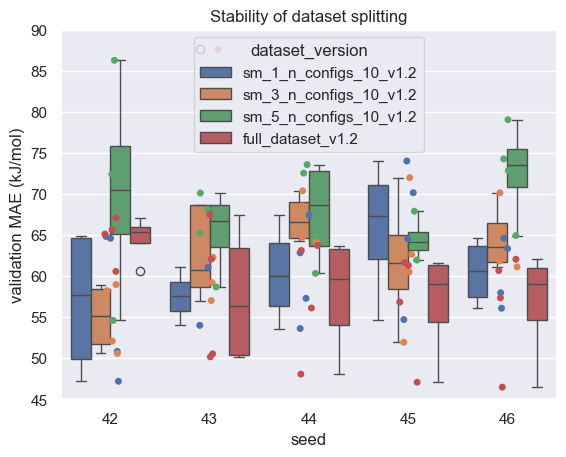

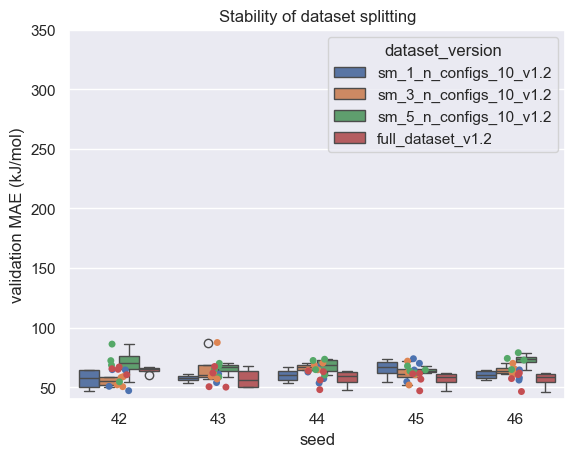

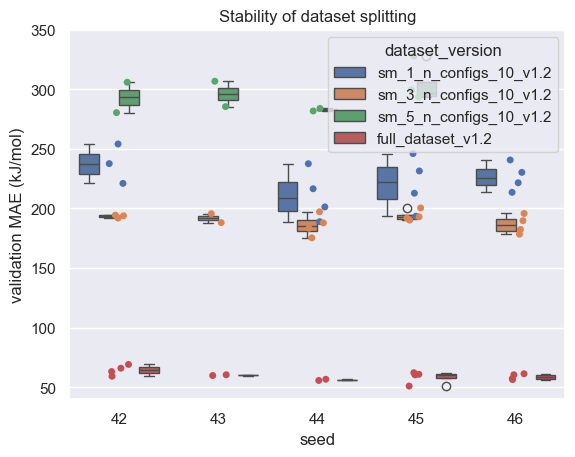

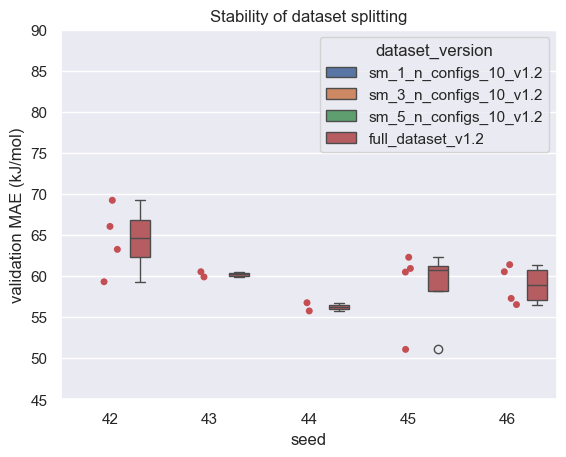

In [29]:
ax = sns.boxplot(
    data=test_results_df,
    x="seed",
    y="val/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=test_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
ax.set_ylim(45, 90)
plt.show()

ax = sns.boxplot(
    data=test_results_df,
    x="seed",
    y="val/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=test_results_df, 
    x="seed", 
    y="val/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
ax.set_ylim(40, 350)
plt.show()

ax = sns.boxplot(
    data=test_results_df,
    x="seed",
    y="test/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=test_results_df, 
    x="seed", 
    y="test/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
ax.set_ylim(40, 350)
plt.show()

ax = sns.boxplot(
    data=test_results_df,
    x="seed",
    y="test/per_system_energy/mae",
    hue="dataset_version",
)
sns.stripplot(
    data=test_results_df, 
    x="seed", 
    y="test/per_system_energy/mae", 
    hue="dataset_version",
    legend=False,
)
ax.set_ylabel("validation MAE (kJ/mol)")
ax.set_title("Stability of dataset splitting")
ax.set_ylim(45, 90)
plt.show()

### Limit to a single spin multiplicity

In [30]:
results_single_spin = test_results_df#[test_results_df["dataset_version"] != "full_dataset_v1.2"]

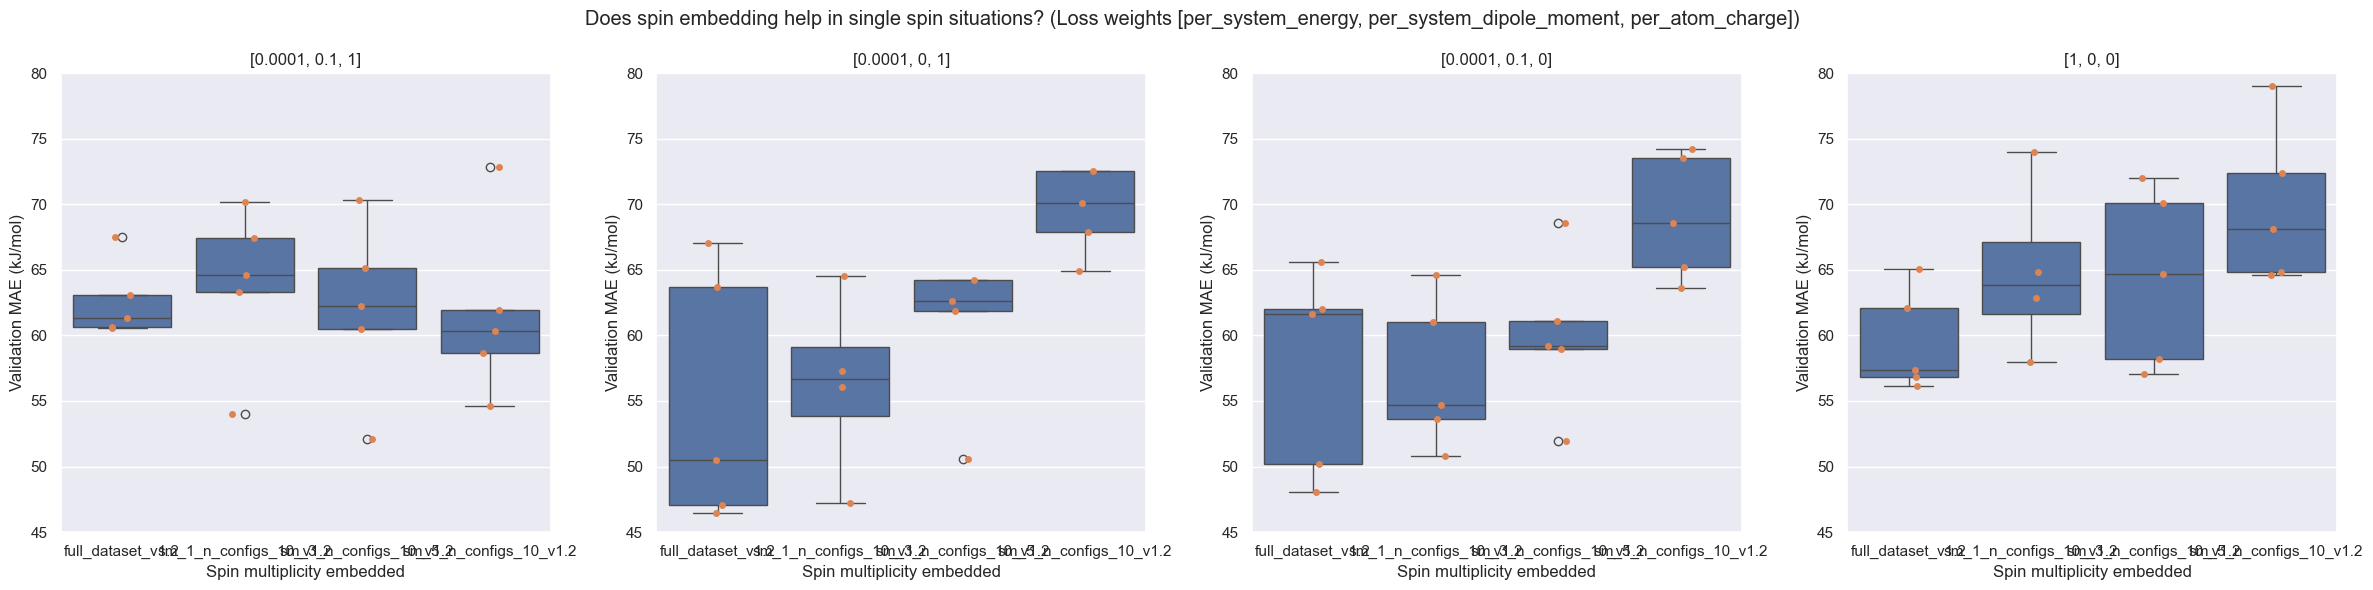

In [41]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin embedding help in single spin situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_version_select = [
    "full_dataset_sm1_v1.1",
    "full_dataset_sm3_v1.1",
    "full_dataset_sm5_v1.1",
]

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_single_spin[
        # (results_single_spin["dataset_version"] == options_version_select[i]) &\
        (results_single_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_single_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_single_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="dataset_version",
        y="val/per_system_energy/mae",
        # hue="dataset_version",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="dataset_version", 
        y="val/per_system_energy/mae", 
        # hue="dataset_version",
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

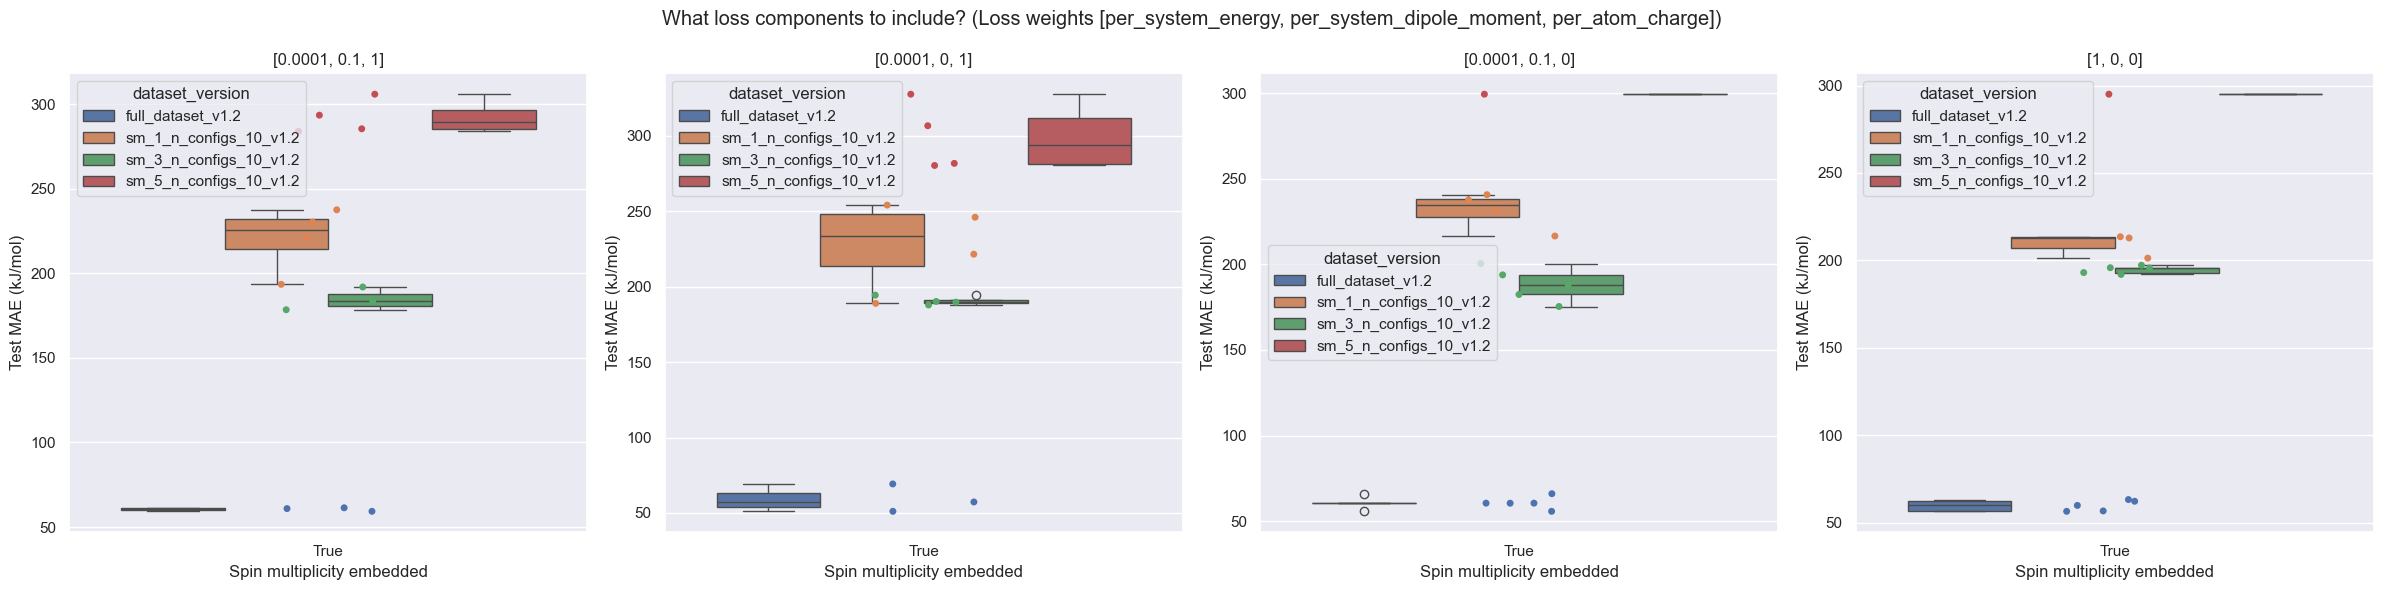

In [39]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("Does spin embedding help in single spin situations? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_version_select = [
    "full_dataset_sm1_v1.1",
    "full_dataset_sm3_v1.1",
    "full_dataset_sm5_v1.1",
]

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_single_spin[
        # (results_single_spin["dataset_version"] == options_version_select[i]) &\
        (results_single_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_single_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_single_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="test/per_system_energy/mae",
        hue="dataset_version",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="test/per_system_energy/mae", 
        hue="dataset_version",
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Test MAE (kJ/mol)")
    # axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### Full dataset comparison

In [33]:
results_multi_spin = test_results_df[test_results_df["dataset_version"] == "full_dataset_v1.2"]

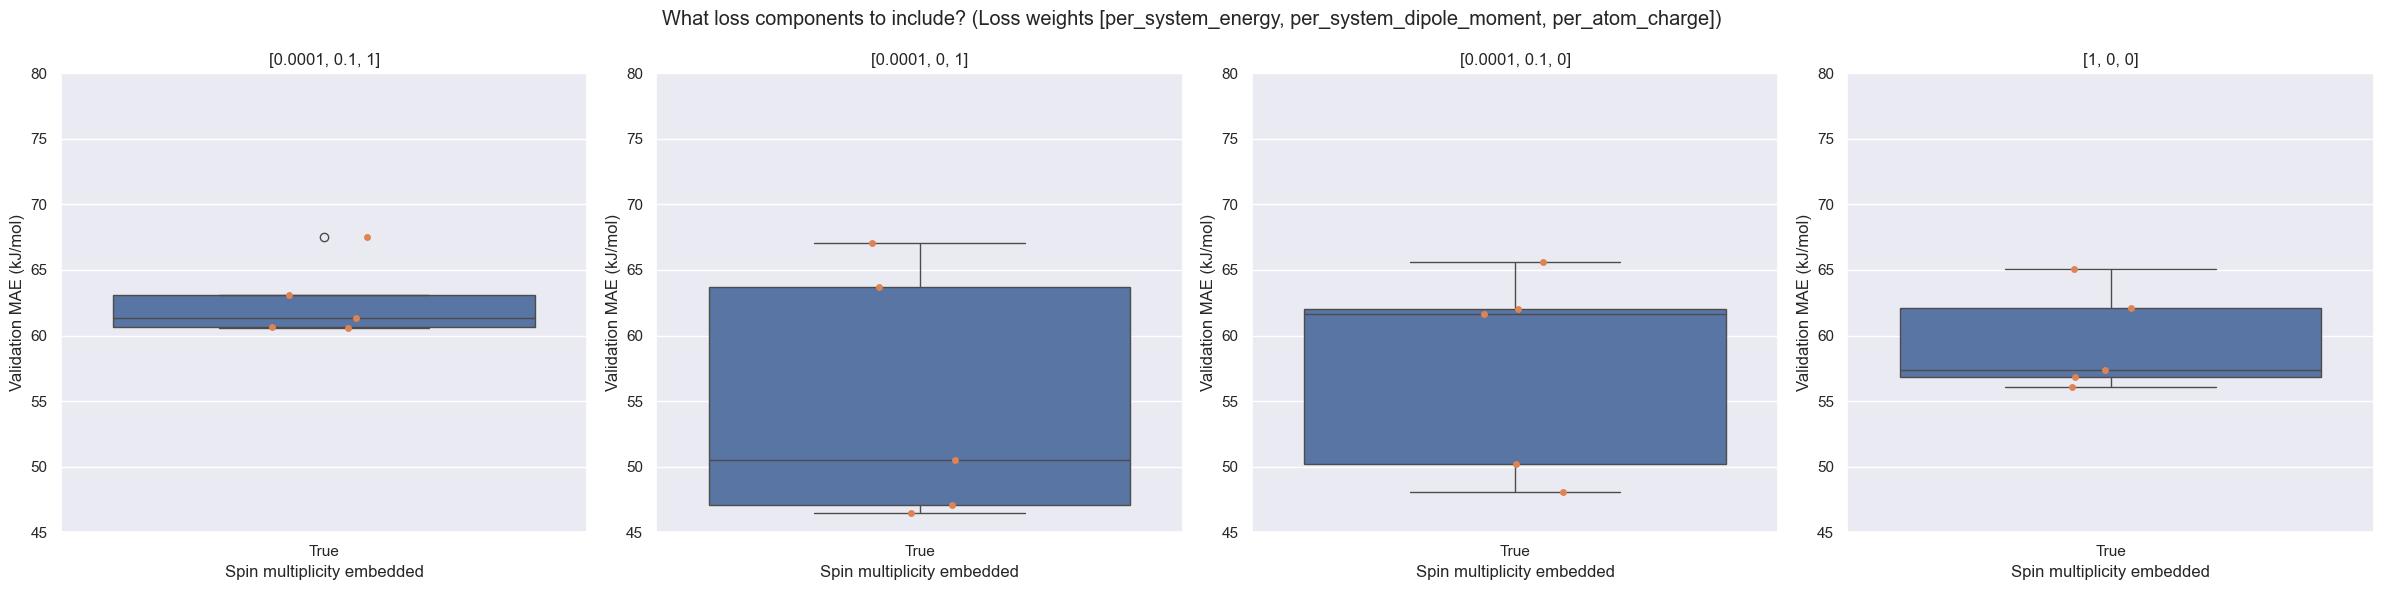

In [40]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("What loss components to include? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="val/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_energy/mae", 
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Validation MAE (kJ/mol)")
    axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

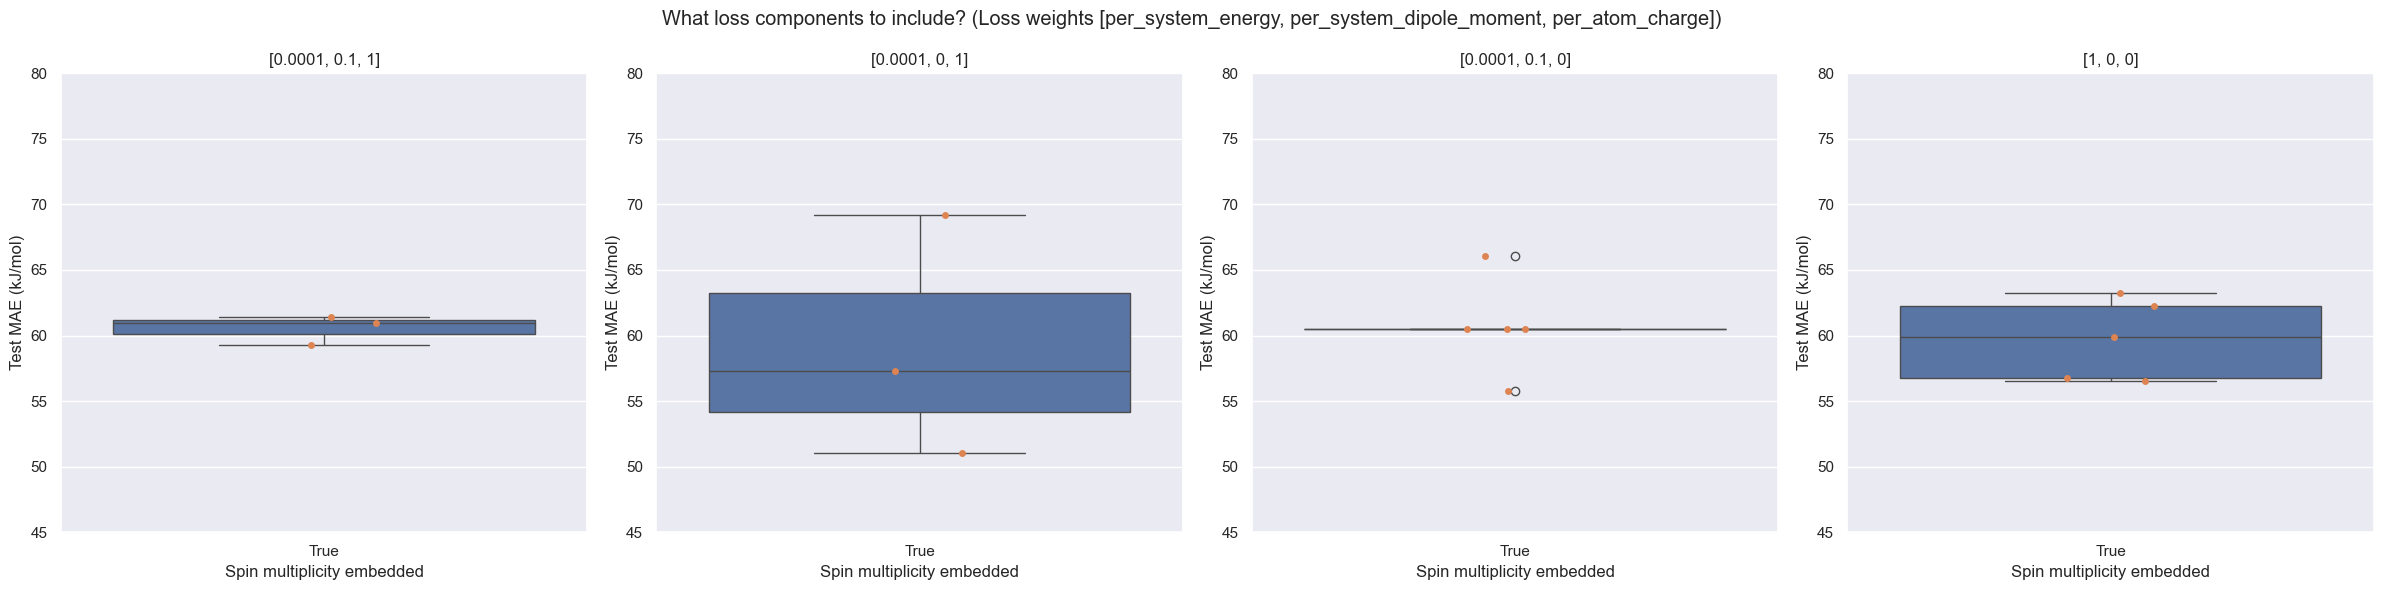

In [38]:
fig, axes = plt.subplots(1, 4, figsize=(24,6))
fig.suptitle("What loss components to include? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")
    
    sns.boxplot(
        ax=axes[j],
        data=data,
        x="spin_embedding",
        y="test/per_system_energy/mae",
    )
    sns.stripplot(
        ax=axes[j],
        data=data, 
        x="spin_embedding", 
        y="test/per_system_energy/mae", 
        legend=False,
    )
    axes[j].set_xlabel("Spin multiplicity embedded")
    axes[j].set_ylabel("Test MAE (kJ/mol)")
    axes[j].set_ylim(45, 80)
    axes[j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### How well are dipole moments and partial charges predicted?

In [36]:
loss_E = results_multi_spin[results_multi_spin["per_system_energy"] == 1]
loss_Emu = results_multi_spin[(results_multi_spin["per_system_dipole_moment"] == 0.1) & (results_multi_spin["per_atom_charge"] == 0)]
loss_Eq  = results_multi_spin[(results_multi_spin["per_system_dipole_moment"] == 0) & (results_multi_spin["per_atom_charge"] == 1)]
loss_Emuq = results_multi_spin[(results_multi_spin["per_system_dipole_moment"] == 0.1) & (results_multi_spin["per_atom_charge"] == 1)]

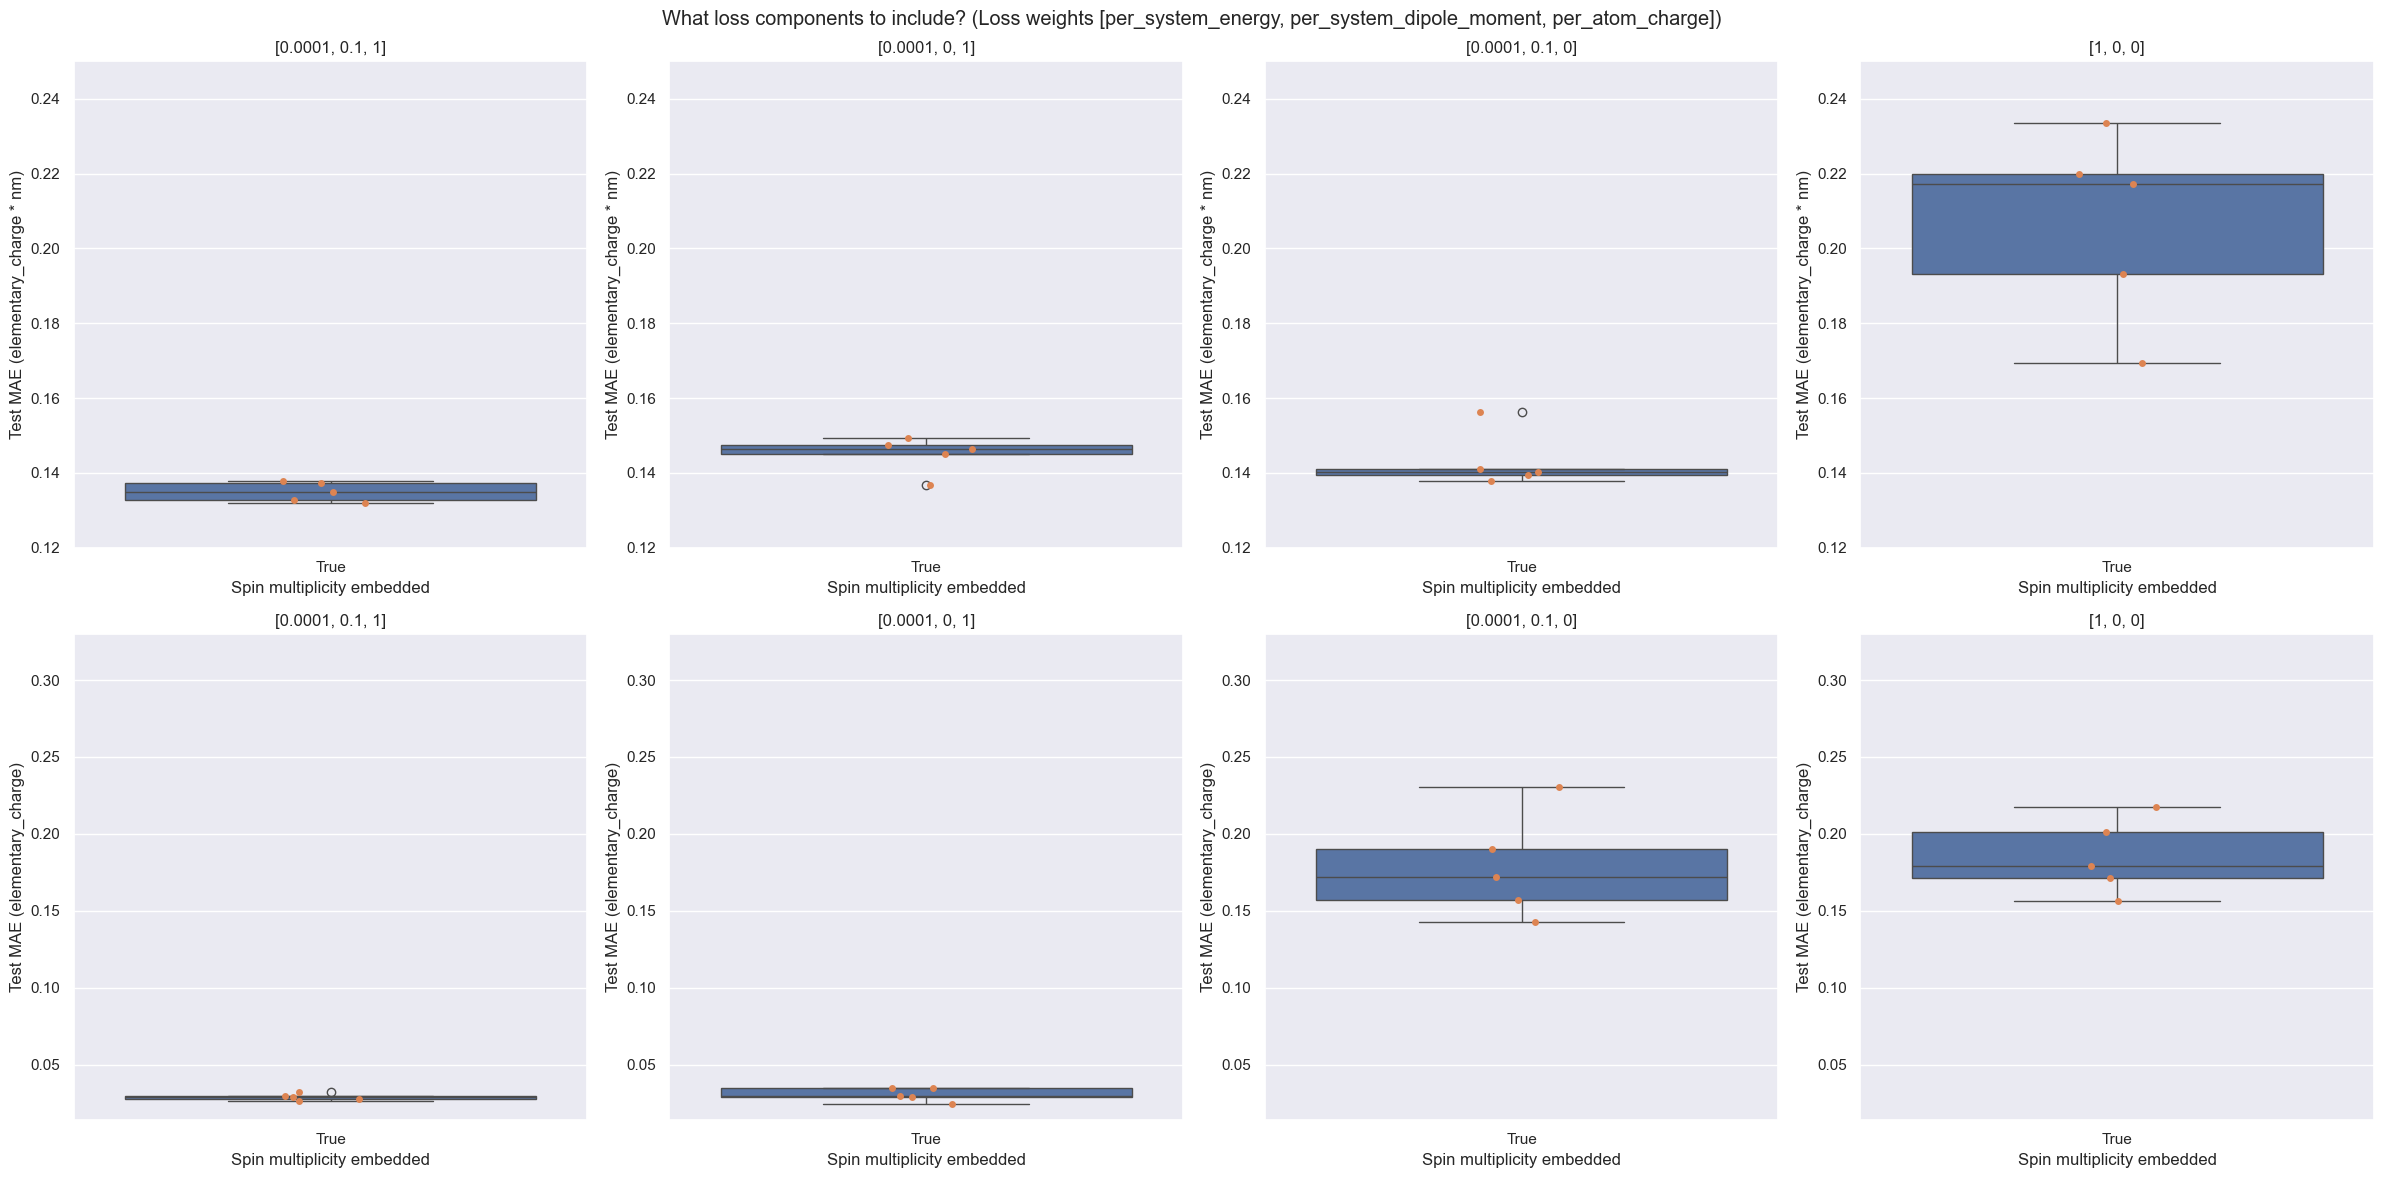

In [37]:
fig, axes = plt.subplots(2, 4, figsize=(24,12))
fig.suptitle("What loss components to include? (Loss weights [per_system_energy, per_system_dipole_moment, per_atom_charge])")

options_loss_components = [
    [0.0001, 0.1, 1],
    [0.0001, 0, 1],
    [0.0001, 0.1, 0],
    [1, 0, 0],
]

for j in range(4):

    data = results_multi_spin[
        (results_multi_spin["per_system_energy"] == options_loss_components[j][0]) &\
        (results_multi_spin["per_system_dipole_moment"] == options_loss_components[j][1]) &\
        (results_multi_spin["per_atom_charge"] == options_loss_components[j][2])
    ].sort_values(by="dataset_version")

    # dipole moment
    sns.boxplot(
        ax=axes[0, j],
        data=data,
        x="spin_embedding",
        y="val/per_system_dipole_moment/mae",
    )
    sns.stripplot(
        ax=axes[0, j],
        data=data, 
        x="spin_embedding", 
        y="val/per_system_dipole_moment/mae", 
        legend=False,
    )
    axes[0, j].set_xlabel("Spin multiplicity embedded")
    axes[0, j].set_ylabel("Test MAE (elementary_charge * nm)")
    axes[0, j].set_ylim(0.12, 0.25)
    axes[0, j].set_title(f"{options_loss_components[j]}")

    # partial charge
    sns.boxplot(
        ax=axes[1, j],
        data=data,
        x="spin_embedding",
        y="val/per_atom_charge/mae",
    )
    sns.stripplot(
        ax=axes[1, j],
        data=data, 
        x="spin_embedding", 
        y="val/per_atom_charge/mae", 
        legend=False,
    )
    axes[1, j].set_xlabel("Spin multiplicity embedded")
    axes[1, j].set_ylabel("Test MAE (elementary_charge)")
    axes[1, j].set_ylim(0.014, 0.33)
    axes[1, j].set_title(f"{options_loss_components[j]}")

fig.tight_layout()

### Evalute with the fixed test dataset

In [21]:
from openff.units import unit


# Define the reference energies for each element in kJ/mol
ase = {
    "H": -1574.9057945240868 * unit.kilojoule_per_mole,
    "C": -100086.51170377462 * unit.kilojoule_per_mole,
    "N": -143801.51483853368 * unit.kilojoule_per_mole,
    "O": -197604.4180833407 * unit.kilojoule_per_mole,
    "F": -262248.6420523814 * unit.kilojoule_per_mole,
    "P": -896364.0735122316 * unit.kilojoule_per_mole,
    "S": -1045654.468887562 * unit.kilojoule_per_mole,
    "Cl": -1208514.2106607035 * unit.kilojoule_per_mole,
    "Fe": -3318371.4922360503 * unit.kilojoule_per_mole,
    "Cu": -4307496.132092452 * unit.kilojoule_per_mole,
    "Zn": -4672271.154058549 * unit.kilojoule_per_mole,
    "Br": -6759287.787427634 * unit.kilojoule_per_mole,
    "Pd": -335891.6546589908 * unit.kilojoule_per_mole,
}

# define the dataset statistics to use if the dataset was normalized

dataset_statistic = {
    "training_dataset_statistics": {
        "per_atom_energy_mean": -5.146267064064403,
        "per_atom_energy_stddev": 6.048297128174876,
    }
}

In [20]:
filename = "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/runs/run077/logs/aimnet2_tmqm_openff/bqftyw6v/checkpoints/best_AimNet2-tmqm_openff_local-epoch=67.ckpt"
potential = load_inference_model_from_checkpoint(filename, jit=False)
potential.to(device="cuda" if torch.cuda.is_available() else "cpu")

2025-08-25 11:36:49.276 | DEBUG    | modelforge.potential.potential:generate_potential:848 - training_parameter=None
2025-08-25 11:36:49.276 | DEBUG    | modelforge.potential.potential:generate_potential:849 - potential_parameter=AimNet2Parameters(potential_name='AimNet2', only_unique_pairs=False, core_parameter=CoreParameter(number_of_radial_basis_functions=64, maximum_interaction_radius=0.49999999999999994, number_of_interaction_modules=3, interaction_module_hidden_layers=[[512, 380], [512, 380], [512, 380, 380]], output_module_hidden_layers=[128, 128], activation_function_parameter=ActivationFunctionConfig(activation_function_name='GeLU', activation_function_arguments=None, activation_function=GELU(approximate='none')), featurization=Featurization(properties_to_featurize=['atomic_number', 'per_system_spin_state'], atomic_number=AtomicNumber(maximum_atomic_number=101, number_of_per_atom_features=128), atomic_period=AtomicPeriod(maximum_period=8, number_of_per_period_features=32), ato

Potential(
  (core_network): AimNet2Core(
    (activation_function): GELU(approximate='none')
    (representation_module): AIMNet2Representation(
      (radial_symmetry_function_module): SchnetRadialBasisFunction(
        (radial_basis_function): GaussianRadialBasisFunctionCore()
      )
      (featurize_input): FeaturizeInput(
        (append_to_embedding_tensor): ModuleList(
          (0): AddPerMoleculeValue()
        )
        (embeddings): ModuleList()
        (atomic_number_embedding): Embedding(101, 128)
        (mixing): DenseWithCustomDist(
          in_features=129, out_features=128, bias=True
          (activation_function): Identity()
        )
      )
      (cutoff_module): CosineAttenuationFunction()
    )
    (interaction_modules): ModuleList(
      (0): AIMNet2InteractionModule(
        (gs_to_fatom): Dense(
          in_features=64, out_features=128, bias=False
          (activation_function): Identity()
        )
        (mlp): Sequential(
          (0): Dense(
      

In [21]:
# if the dataset was normalized we need to unnormalize the energy
# to compare with the reference energies in the hdf5 dataset
unnormalize_energy = False

import h5py

# define the input file name of the hdf5 file that contains the fixed test subset
input_filename = "/Users/syan/workdir/modelforge-experiments/experiments/exp08_3/cache/fixed_test_subset/fixed_test_subset_v1.2.hdf5"

from tqdm import tqdm
from dataclasses import dataclass
from modelforge.dataset.utils import _ATOMIC_NUMBER_TO_ELEMENT
from modelforge.utils.prop import NNPInput

In [22]:
energy_diff = []
energy_ref = []
energy_pred = []


snapshots = []
molecule_names = []
with h5py.File(input_filename, "r") as f:
    keys = list(f.keys())

    for key in tqdm(keys):

        # grab all the data from the hdf5 file
        # we could certainly write some helper functions to do this better
        # e.g., loading this into a SourceDataset class instance and accessing
        # each record by key
        atomic_numbers = f[key]["atomic_numbers"][()]
        positions = f[key]["positions"][()]
        energy_key = "dft_total_energy"
        energy = f[key][energy_key][()] * unit.Unit(
            f[key][energy_key].attrs["u"]
        ) - calculate_reference_energy(atomic_numbers, ase)
        total_charge = f[key]["total_charge"][()]
        number_of_atoms = atomic_numbers.shape[0]
        n_configs = f[key]["n_configs"][()]
        spin_multiplicity = f[key]["per_system_spin_multiplicity"][()]
        from modelforge.utils.prop import NNPInput

        for n_config in range(n_configs):
            # print(f"Processing config {n_config} of {n_configs}")

            # could create a helper function to convert a record to NNPInput based on the properties association dict in
            # the toml files.
            nnp_input = NNPInput(
                atomic_numbers=torch.tensor(
                    atomic_numbers.squeeze(), dtype=torch.int32
                ),
                positions=torch.tensor(
                    positions[n_config].reshape(-1, 3), dtype=torch.float32
                ),
                per_system_total_charge=torch.tensor(
                    total_charge[n_config].reshape(-1, 1), dtype=torch.float32
                ),
                atomic_subsystem_indices=torch.zeros(
                    number_of_atoms, dtype=torch.int32
                ),
                per_system_spin_state=torch.tensor(
                    spin_multiplicity[n_config].reshape(-1, 1), dtype=torch.float32
                ),
            )
            nnp_input.to_device(device="cuda" if torch.cuda.is_available() else "cpu")
            molecule_names.append(key)
            output = potential(nnp_input)

            energy_temp = (
                output["per_system_energy"].cpu().detach().numpy().reshape(-1)[0]
            )
            if unnormalize_energy:
                energy_temp = (
                    energy_temp
                    * dataset_statistic["training_dataset_statistics"][
                        "per_atom_energy_stddev"
                    ]
                    + dataset_statistic["training_dataset_statistics"][
                        "per_atom_energy_mean"
                    ]
                )
            energy_diff.append(float((energy_temp - energy[n_config].m).reshape(-1)[0]))
            energy_red.append(float(energy_temp.reshape(-1)[0]))
            energy_ref.append(float(energy[n_config].m.reshape(-1)[0]))


  0%|          | 0/1734 [00:00<?, ?it/s]


NameError: name 'energy_red' is not defined